## 1. Imports & global settings


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets
from ipywidgets import interactive_output, VBox, HBox, Output
from IPython.display import display

from sklearn.neighbors import KernelDensity

from scipy.signal import savgol_filter
from scipy.ndimage import median_filter
from sklearn.linear_model import LinearRegression

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pyarrow as pa

try:
    pa.unregister_extension_type("pandas.period")
except Exception:
    pass





plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.grid'] = True


### 1.1 Analysis parameters

These settings are applied to **all** parquets.


In [3]:
# Segmentation and preprocessing parameters (applied to all parquets)
GAP_THRESHOLD_SECONDS = 3600   # split segment if gap > 1 hour
MIN_POINTS_PER_SEGMENT = 100   # minimum rows per segment
EMA_ALPHA = 0.1                # smoothing factor (0 < alpha <= 1)


## 2. Signal mapping

Mapping between `signal_id` and human-readable signal names and metadata.


In [4]:
mapping = {
    'signal_id': [8890,9620,9619,11247,11333,11331,16769,15454,15453,16679,14156,14154,
                  26499,30654,30653,29296,29388,29386,16796,24141,24140,25120,25207,25205,
                  18263,19318,19317,21058,21145,21143],
    'measurement_unit': ['MW','', '', '%','bar','bar','MW','','','%','bar','bar',
                         'MW','','','%','bar','bar','MW','','','%','bar','bar',
                         'MW','','','%','bar','bar'],
    'type_id': ['measurement (analog)','Bool','Bool','measurement (analog)','measurement (analog)','measurement (analog)',
                'measurement (analog)','Bool','Bool','measurement (analog)','measurement (analog)','measurement (analog)',
                'measurement (analog)','Bool','Bool','measurement (analog)','measurement (analog)','measurement (analog)',
                'measurement (analog)','Bool','Bool','measurement (analog)','measurement (analog)','measurement (analog)',
                'measurement (analog)','Bool','Bool','measurement (analog)','measurement (analog)','measurement (analog)'],
    'plant': ['KSL']*30,
    'stage': ['Mapragg','Mapragg','Mapragg','Mapragg','Mapragg','Mapragg',
              'Sarelli','Sarelli','Sarelli','Sarelli','Sarelli','Sarelli',
              'Mapragg','Mapragg','Mapragg','Mapragg','Mapragg','Mapragg',
              'Sarelli','Sarelli','Sarelli','Sarelli','Sarelli','Sarelli',
              'Mapragg','Mapragg','Mapragg','Mapragg','Mapragg','Mapragg'],
    'machine_group': ['MG1','MG1','MG1','MG1','MG1','MG1',
                      'MG1','MG1','MG1','MG1','MG1','MG1',
                      'MG2','MG2','MG2','MG2','MG2','MG2',
                      'MG2','MG2','MG2','MG2','MG2','MG2',
                      'MG3','MG3','MG3','MG3','MG3','MG3'],
    'signal_name': ['active_power','ball_valve_closed','ball_valve_open','guide_vane_position',
                    'water_pressure_downstream','water_pressure_upstream',
                    'active_power','ball_valve_closed','ball_valve_open','guide_vane_position',
                    'water_pressure_downstream','water_pressure_upstream',
                    'active_power','ball_valve_closed','ball_valve_open','guide_vane_position',
                    'water_pressure_downstream','water_pressure_upstream',
                    'active_power','ball_valve_closed','ball_valve_open','guide_vane_position',
                    'water_pressure_downstream','water_pressure_upstream',
                    'active_power','ball_valve_closed','ball_valve_open','guide_vane_position',
                    'water_pressure_downstream','water_pressure_upstream'],
    'description': [
        'Active power measurement',
        'Ball valve position rotating body closed (true if valve is fully closed)',
        'Ball valve position rotating body open (true if valve is fully open)',
        'Guide vane position measurement',
        'water pressure downstream of the turbine',
        'water pressure upstream of the turbine',
        'Active power measurement',
        'Ball valve position rotating body closed (true if valve is fully closed)',
        'Ball valve position rotating body open (true if valve is fully open)',
        'Guide vane position measurement',
        'water pressure downstream of the turbine',
        'water pressure upstream of the turbine',
        'Active power measurement',
        'Ball valve position rotating body closed (true if valve is fully closed)',
        'Ball valve position rotating body open (true if valve is fully open)',
        'Guide vane position measurement',
        'water pressure downstream of the turbine',
        'water pressure upstream of the turbine',
        'Active power measurement',
        'Ball valve position rotating body closed (true if valve is fully closed)',
        'Ball valve position rotating body open (true if valve is fully open)',
        'Guide vane position measurement',
        'water pressure downstream of the turbine',
        'water pressure upstream of the turbine',
        'Active power measurement',
        'Ball valve position rotating body closed (true if valve is fully closed)',
        'Ball valve position rotating body open (true if valve is fully open)',
        'Guide vane position measurement',
        'water pressure downstream of the turbine',
        'water pressure upstream of the turbine',
    ]
}

df_mapping = pd.DataFrame(mapping)
df_mapping.head()

,signal_id,measurement_unit,type_id,plant,stage,machine_group,signal_name,description
0,8890,MW,measurement (analog),KSL,Mapragg,MG1,active_power,Active power measurement
1,9620,,Bool,KSL,Mapragg,MG1,ball_valve_closed,Ball valve position rotating body closed (true...
2,9619,,Bool,KSL,Mapragg,MG1,ball_valve_open,Ball valve position rotating body open (true i...
3,11247,%,measurement (analog),KSL,Mapragg,MG1,guide_vane_position,Guide vane position measurement
4,11333,bar,measurement (analog),KSL,Mapragg,MG1,water_pressure_downstream,water pressure downstream of the turbine


## 3. Helper functions

Functions for gap analysis, segmentation, extraction, smoothing and correlation.


In [5]:
def analyze_gaps(df, time_col='ts_sec'):
    """Print basic gap statistics for a given dataframe."""
    arr = np.sort(df[time_col].unique())
    if len(arr) < 2:
        print('Not enough points for gap analysis.')
        return
    diffs = np.diff(arr)
    print('Gap analysis:')
    print(f'  Min gap: {diffs.min():.2f} s')
    print(f'  Max gap: {diffs.max():.2f} s')
    print(f'  Mean gap: {diffs.mean():.2f} s')
    print(f'  Median gap: {np.median(diffs):.2f} s')
    print(f'  95th percentile: {np.percentile(diffs, 95):.2f} s')
    print(f'  99th percentile: {np.percentile(diffs, 99):.2f} s')


In [6]:
def create_synchronized_segments(df, gap_threshold_seconds=3600, min_points=1):
    """Split dataframe into segments based on gaps in `ts_sec`.

    Parameters
    ----------
    df : DataFrame with column 'ts_sec'
    gap_threshold_seconds : float, gap > threshold triggers a new segment
    min_points : int, minimum number of rows to keep a segment
    """
    df_sorted = df.sort_values('ts_sec').reset_index(drop=True)
    all_ts = np.sort(df_sorted['ts_sec'].unique())
    if len(all_ts) == 0:
        return []
    if len(all_ts) == 1:
        return [df_sorted]

    diffs = np.diff(all_ts)
    gap_indices = np.where(diffs > gap_threshold_seconds)[0]

    segments = []
    start_idx = 0

    def add_segment(seg):
        if len(seg) >= min_points:
            segments.append(seg)

    for gap_idx in gap_indices:
        start_time = all_ts[start_idx]
        end_time = all_ts[gap_idx]
        seg = df_sorted[(df_sorted['ts_sec'] >= start_time) &
                        (df_sorted['ts_sec'] <= end_time)].copy()
        add_segment(seg)
        start_idx = gap_idx + 1

    # final segment
    start_time = all_ts[start_idx]
    end_time = all_ts[-1]
    seg = df_sorted[(df_sorted['ts_sec'] >= start_time) &
                    (df_sorted['ts_sec'] <= end_time)].copy()
    add_segment(seg)
    return segments


In [7]:
def extract_and_normalize(segments, signal_name):
    """Extract given signal from each segment and normalize time so t0 = 0.

    Returns a list of dataframes with an extra column 't0_sec'.
    """
    result = []
    for seg in segments:
        sub = seg[seg['signal_name'] == signal_name].copy()
        if not sub.empty:
            segment_start = seg['ts_sec'].min()
            sub['t0_sec'] = sub['ts_sec'] - segment_start

            result.append(sub)
    return result


In [8]:
def get_sampling_rate(df_signal):
    """Estimate sampling rate (Hz) and average interval (s) for a signal segment."""
    if len(df_signal) < 2:
        return None, None
    df_signal = df_signal.sort_values('ts_sec')
    time_diff = np.diff(df_signal['ts_sec'].values)
    avg_interval = np.mean(time_diff)
    sampling_rate = 1.0 / avg_interval if avg_interval != 0 else None
    return sampling_rate, avg_interval


In [9]:
def apply_ffill_to_segments(segments):
    """Apply forward fill to each dataframe in a list of segments."""
    return [seg.ffill() for seg in segments]


In [10]:
def ema(data, alpha):
    """Compute Exponential Moving Average for a 1D array-like."""
    data = np.asarray(data, dtype=float)
    if data.size == 0:
        return data
    ema_values = np.zeros_like(data, dtype=float)
    ema_values[0] = data[0]
    for i in range(1, len(data)):
        ema_values[i] = alpha * data[i] + (1 - alpha) * ema_values[i - 1]
    return ema_values


In [11]:
def apply_ema_to_value(segments, alpha):
    """Apply EMA to the 'value' column in each segment."""
    result = []
    for seg in segments:
        seg_ema = seg.copy()
        seg_ema['value'] = ema(seg['value'].values, alpha)
        result.append(seg_ema)
    return result


## 4. Discover parquet files

We look for all `*_real_measurements.parquet` files in the current directory.


In [12]:
parquet_files = sorted(
    [f for f in os.listdir('.')
     if f.endswith('.parquet') and 'real_measurements' in f]
)

print('Found parquet files:')
for f in parquet_files:
    print('  -', f)


Found parquet files:
  - Mapragg_MG1_testing_real_measurements.parquet
  - Mapragg_MG1_training_real_measurements.parquet
  - Mapragg_MG2_testing_real_measurements.parquet
  - Mapragg_MG2_training_real_measurements.parquet
  - Mapragg_MG3_testing_real_measurements.parquet
  - Mapragg_MG3_training_real_measurements.parquet
  - Sarelli_MG1_testing_real_measurements.parquet
  - Sarelli_MG1_training_real_measurements.parquet
  - Sarelli_MG2_testing_real_measurements.parquet
  - Sarelli_MG2_training_real_measurements.parquet


In [13]:
all_raw = {}

for f in parquet_files:
    print("Loading:", f)
    df = pd.read_parquet(f)

    # Ensure expected columns exist
    needed = {"ts", "signal_id", "value"}
    if not needed.issubset(df.columns):
        raise ValueError(f"{f} missing required columns: {needed - set(df.columns)}")

    # Convert timestamp to seconds float
    df["ts"] = pd.to_datetime(df["ts"])
    df["ts_sec"] = df["ts"].astype("int64") / 1e9 
    
    # Merge with mapping
    dfm = df.merge(df_mapping, on="signal_id", how="left")

    # Structure storage
    all_raw[f] = {
        "stage": dfm["stage"].iloc[0],
        "machine_group": dfm["machine_group"].iloc[0],
        "dataset_type": "raw",
        "signals": {}
    }

    # Build raw arrays per signal_name
    for sig in df_mapping.signal_name.unique():
        sdf = dfm[dfm.signal_name == sig].sort_values("ts_sec")

        all_raw[f]["signals"][sig] = {
            "ts_sec": sdf["ts_sec"].to_numpy(),
            "value":  sdf["value"].to_numpy(),
        }

print("\nFinished building all_raw.")


Loading: Mapragg_MG1_testing_real_measurements.parquet


Loading: Mapragg_MG1_training_real_measurements.parquet
Loading: Mapragg_MG2_testing_real_measurements.parquet
Loading: Mapragg_MG2_training_real_measurements.parquet
Loading: Mapragg_MG3_testing_real_measurements.parquet
Loading: Mapragg_MG3_training_real_measurements.parquet
Loading: Sarelli_MG1_testing_real_measurements.parquet
Loading: Sarelli_MG1_training_real_measurements.parquet
Loading: Sarelli_MG2_testing_real_measurements.parquet
Loading: Sarelli_MG2_training_real_measurements.parquet

Finished building all_raw.


In [14]:
def show_raw_file(filename):

    if filename not in all_raw:
        print("No raw data for:", filename)
        return

    group = all_raw[filename]

    stage         = group["stage"]
    machine_group = group["machine_group"]
    dataset_type  = group["dataset_type"]

    signals_to_plot = [
        "active_power",
        "guide_vane_position",
        "water_pressure_downstream",
        "water_pressure_upstream",
        "ball_valve_closed",
        "ball_valve_open",
    ]

    # Units corresponding to signals
    units = ["[W]", "[%]", "[bar]", "[bar]", "[-]", "[-]"]

    fig, axes = plt.subplots(
        len(signals_to_plot), 1,
        figsize=(12, 2.6 * len(signals_to_plot)),
        sharex=False
    )

    if len(signals_to_plot) == 1:
        axes = [axes]

    # Use matplotlib's default color cycle
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for ax, sig, unit, color in zip(axes, signals_to_plot, units, color_cycle):

        raw = group["signals"][sig]

        if sig in ["ball_valve_closed", "ball_valve_open"]:
            ax.plot(raw["ts_sec"], raw["value"], ".", markersize=5, color=color)
        else:
            ax.plot(raw["ts_sec"], raw["value"], linewidth=1, color=color)

        pretty_sig = sig.replace("_", " ").capitalize()

        ax.set_ylabel(f"{pretty_sig} {unit}", fontsize=9)
        ax.set_xlabel("time [s]", fontsize=9)
        ax.grid(True, alpha=0.3)

    fig.suptitle(
        f"{filename} — RAW DATA\n",
        fontsize=12,
        y=1.02
    )

    plt.tight_layout()
    plt.show()



In [15]:
raw_file_dropdown = widgets.Dropdown(
    options=parquet_files,
    description="Parquet"
)

raw_out = widgets.interactive_output(
    show_raw_file,
    {"filename": raw_file_dropdown}
)

display(VBox([raw_file_dropdown, raw_out]))


## 5. Main loop over parquets

For each parquet we perform the full analysis pipeline, completely independently.


In [16]:
all_sampling_stats = {}

all_segments = {}   # dictionary to keep segments for interactive plotting

for path in parquet_files:
    print('\n' + '='*80)
    print(f'Analyzing file: {path}')
    print('='*80)

    # Try to infer stage/machine group/dataset type from filename
    base = os.path.basename(path)
    name_no_ext = base.replace('.parquet', '')
    parts = name_no_ext.split('_')
    stage = parts[0] if len(parts) > 0 else 'UnknownStage'
    machine_group = parts[1] if len(parts) > 1 else 'UnknownMG'
    dataset_type = parts[2] if len(parts) > 2 else 'UnknownType'

    print(f'Stage: {stage}, Machine group: {machine_group}, Dataset type: {dataset_type}')

    # ---------------- Load parquet ----------------
    df = pd.read_parquet(path, engine='pyarrow')
    print('Raw dataframe shape:', df.shape)

    if 'ts' not in df.columns:
        raise ValueError(f"Column 'ts' not found in {path}")

    if not pd.api.types.is_datetime64_any_dtype(df['ts']):
        df['ts'] = pd.to_datetime(df['ts'])
    if getattr(df['ts'].dt, "tz", None) is not None:
        df['ts'] = df['ts'].dt.tz_convert(None)

    if 'signal_id' not in df.columns:
        raise ValueError(f"Column 'signal_id' not found in {path}")

    df = df.merge(df_mapping, on='signal_id', how='inner')
    print('After mapping, shape:', df.shape)

    df['ts_sec'] = (df['ts'] - df['ts'].min()).dt.total_seconds()

    if stage in df_mapping['stage'].unique().tolist():
        df = df[df['stage'] == stage]
    if machine_group in df_mapping['machine_group'].unique().tolist():
        df = df[df['machine_group'] == machine_group]

    print('After filtering by mapping stage/MG, shape:', df.shape)

    if df.empty:
        print('No data left after stage/MG filtering – skipping file.')
        continue

    # ---------------- Gap analysis ----------------
    analyze_gaps(df)

    # ---------------- Segmentation ----------------
    segments = create_synchronized_segments(
        df,
        gap_threshold_seconds=GAP_THRESHOLD_SECONDS,
        min_points=MIN_POINTS_PER_SEGMENT,
    )

    print(f'Number of segments: {len(segments)}')
    for i, seg in enumerate(segments, start=1):
        print(f'\nSegment {i}:')
        print('  Points:', len(seg))
        print('  Time range:', seg['ts'].min(), '->', seg['ts'].max())
        print('  Duration [s]:', seg['ts_sec'].max() - seg['ts_sec'].min())
        print('  Signals present:', seg['signal_name'].unique().tolist())

    if not segments:
        print('No segments created – skipping.')
        continue

    # ---------------- Extract & normalize signals ----------------
    df_closed_raw = extract_and_normalize(segments, 'ball_valve_closed')
    df_open_raw   = extract_and_normalize(segments, 'ball_valve_open')
    df_pwr_raw    = extract_and_normalize(segments, 'active_power')
    df_vane_raw   = extract_and_normalize(segments, 'guide_vane_position')
    df_down_raw   = extract_and_normalize(segments, 'water_pressure_downstream')
    df_up_raw     = extract_and_normalize(segments, 'water_pressure_upstream')

    df_closed_ff = apply_ffill_to_segments(df_closed_raw)
    df_open_ff   = apply_ffill_to_segments(df_open_raw)
    df_pwr_ff    = apply_ffill_to_segments(df_pwr_raw)
    df_vane_ff   = apply_ffill_to_segments(df_vane_raw)
    df_down_ff   = apply_ffill_to_segments(df_down_raw)
    df_up_ff     = apply_ffill_to_segments(df_up_raw)

    res_pwr   = apply_ema_to_value(df_pwr_ff,  EMA_ALPHA)
    res_vane  = apply_ema_to_value(df_vane_ff, EMA_ALPHA)
    res_down  = apply_ema_to_value(df_down_ff, EMA_ALPHA)
    res_up    = apply_ema_to_value(df_up_ff,   EMA_ALPHA)

    bin_closed = df_closed_ff
    bin_open   = df_open_ff

    all_segments[base] = {
        "active_power": res_pwr,
        "guide_vane_position": res_vane,
        "water_pressure_downstream": res_down,
        "water_pressure_upstream": res_up,
        "ball_valve_closed": bin_closed,
        "ball_valve_open": bin_open,
        "stage": stage,
        "machine_group": machine_group,
        "dataset_type": dataset_type
    }

    print('\n===================== SAMPLING RATE DIAGNOSTICS ====================')

    signals = {
        'ball_valve_closed': df_closed_ff,
        'ball_valve_open':   df_open_ff,
        'active_power':      df_pwr_ff,
        'guide_vane_position': df_vane_ff,
        'water_pressure_downstream': df_down_ff,
        'water_pressure_upstream':   df_up_ff,
    }

    sampling_rates_per_parquet = {}

    for sig_name, seg_list in signals.items():
        print(f"\nSignal: {sig_name}")

        sigid_rates = {} 

        for seg in seg_list:
            sid = seg["signal_id"].iloc[0]
            rate, interval = get_sampling_rate(seg)

            if rate is None:
                continue

            if sid not in sigid_rates:
                sigid_rates[sid] = []
            sigid_rates[sid].append(rate)

        if not sigid_rates:
            print("  No valid sampling rates found.")
            continue

        sampling_rates_per_parquet[sig_name] = {}

        for sid, rates in sigid_rates.items():
            avg_rate = np.mean(rates)
            sampling_rates_per_parquet[sig_name][sid] = avg_rate

            print(f"  Signal ID {sid:>5} → Avg sampling rate: {avg_rate:.4f} Hz "
                  f"(from {len(rates)} segments)")

    # store this parquet's stats
    all_sampling_stats[base] = sampling_rates_per_parquet


print("\n\n==================== FINAL SAMPLING RATE SUMMARY =====================\n")

for parquet_name, parquet_info in all_sampling_stats.items():
    print(f"Parquet: {parquet_name}")
    print("-" * 70)

    for sig_name, sigid_info in parquet_info.items():
        print(f"  {sig_name}:")
        if not sigid_info:
            print("    No sampling data found.")
            continue

        for sid, avg_rate in sigid_info.items():
            print(f"    Signal ID {sid} → Avg sampling rate: {avg_rate:.4f} Hz")

    print("\n")


mapragg_rates = {}
sarelli_rates = {}

# Initialize structure
signals_expected = [
    "ball_valve_closed",
    "ball_valve_open",
    "active_power",
    "guide_vane_position",
    "water_pressure_downstream",
    "water_pressure_upstream",
]

for sig in signals_expected:
    mapragg_rates[sig] = []
    sarelli_rates[sig] = []

# Collect values
for parquet_name, parquet_info in all_sampling_stats.items():

    for sig_name, sid_dict in parquet_info.items():
        for sid, avg_rate in sid_dict.items():

            if avg_rate is None:
                continue

            if parquet_name.startswith("Mapragg"):
                mapragg_rates[sig_name].append(avg_rate)

            elif parquet_name.startswith("Sarelli"):
                sarelli_rates[sig_name].append(avg_rate)

# Compute averages
mapragg_avg = {sig: (np.mean(vals) if vals else None)
               for sig, vals in mapragg_rates.items()}

sarelli_avg = {sig: (np.mean(vals) if vals else None)
               for sig, vals in sarelli_rates.items()}

print("\n===================== MAPRAGG AVERAGE SAMPLING RATES =====================")
for sig, avg in mapragg_avg.items():
    print(f"{sig:30s} : {avg:.4f} Hz" if avg is not None else f"{sig:30s} : No data")

print("\n===================== SARELLI AVERAGE SAMPLING RATES =====================")
for sig, avg in sarelli_avg.items():
    print(f"{sig:30s} : {avg:.4f} Hz" if avg is not None else f"{sig:30s} : No data")




Analyzing file: Mapragg_MG1_testing_real_measurements.parquet
Stage: Mapragg, Machine group: MG1, Dataset type: testing
Raw dataframe shape: (1066195, 4)
After mapping, shape: (1066195, 11)
After filtering by mapping stage/MG, shape: (1066195, 12)
Gap analysis:
  Min gap: 0.00 s
  Max gap: 401748.80 s
  Mean gap: 5.89 s
  Median gap: 2.09 s
  95th percentile: 20.22 s
  99th percentile: 41.49 s
Number of segments: 3

Segment 1:
  Points: 527680
  Time range: 2021-07-20 15:34:12.633000 -> 2021-08-11 20:39:21.655000
  Duration [s]: 1919109.022
  Signals present: ['water_pressure_upstream', 'guide_vane_position', 'water_pressure_downstream', 'ball_valve_closed', 'ball_valve_open', 'active_power']

Segment 2:
  Points: 467935
  Time range: 2021-08-16 12:15:10.457000 -> 2021-09-21 07:09:03.527000
  Duration [s]: 3092033.0700000003
  Signals present: ['guide_vane_position', 'water_pressure_upstream', 'water_pressure_downstream', 'active_power', 'ball_valve_closed', 'ball_valve_open']

Segmen

In [17]:
def show_raw_segment(filename, seg_index):

    if filename not in all_segments:
        print("No data found for this file.")
        return

    group = all_segments[filename]
    ref_segments = group["active_power"]

    if len(ref_segments) == 0:
        print("This file has no segments.")
        return

    if seg_index >= len(ref_segments):
        print(f"Segment index {seg_index} out of range.")
        return

    stage         = group["stage"]
    machine_group = group["machine_group"]
    dataset_type  = group["dataset_type"]

    signals = [
        "active_power",
        "guide_vane_position",
        "water_pressure_downstream",
        "water_pressure_upstream",
        "ball_valve_closed",
        "ball_valve_open",
    ]

    units = {
        "active_power": "[W]",
        "guide_vane_position": "[%]",
        "water_pressure_downstream": "[bar]",
        "water_pressure_upstream": "[bar]",
        "ball_valve_closed": "[-]",
        "ball_valve_open": "[-]",
    }

    colors = [
        "tab:blue",
        "tab:orange",
        "tab:green",
        "tab:red",
        "tab:purple",
        "tab:brown",
    ]

    fig, axes = plt.subplots(len(signals), 1,
                             figsize=(12, 2.6 * len(signals)),
                             sharex=False) 

    if len(signals) == 1:
        axes = [axes]

    for ax, sig, color in zip(axes, signals, colors):
        seg_list = group[sig]
        seg = seg_list[seg_index]

        label_clean = sig.replace("_", " ")
        label_full = f"{label_clean} {units[sig]}"

        if sig in ["ball_valve_closed", "ball_valve_open"]:
            ax.plot(seg["t0_sec"], seg["value"], ".", markersize=6, color=color)
        else:
            ax.plot(seg["t0_sec"], seg["value"], linewidth=1, color=color)

        ax.set_ylabel(label_full, fontsize=9)
        ax.set_xlabel("time [s]", fontsize=9)
        ax.grid(True, alpha=0.3)

    fig.suptitle(
        f"{filename} — Segment {seg_index+1}\n",
        fontsize=12,
        y=1.02
    )

    plt.tight_layout()
    plt.show()


file_dropdown = widgets.Dropdown(
    options=sorted(list(all_segments.keys())),
    description="Parquet"
)

seg_slider = widgets.IntSlider(
    min=0, max=0, step=1, value=0,
    description="Segment"
)

# Update segment slider whenever parquet changes
def update_segment_slider(*args):
    fname = file_dropdown.value
    if fname in all_segments:
        seg_slider.max = max(0, len(all_segments[fname]["active_power"]) - 1)
    else:
        seg_slider.max = 0
    seg_slider.value = 0

file_dropdown.observe(update_segment_slider, names="value")
update_segment_slider()

# Hook viewer to widgets
out = interactive_output(
    show_raw_segment,
    {
        "filename": file_dropdown,
        "seg_index": seg_slider
    }
)

# Display UI
display(VBox([file_dropdown, seg_slider, out]))


# Resampling


In [18]:

def compute_fastest_rate(sampling_dict):
    """Return fastest sampling rate (Hz) inside a parquet."""
    fastest = 0.0
    for sig_name, sid_dict in sampling_dict.items():
        for sid, rate in sid_dict.items():
            if rate is not None and rate > fastest:
                fastest = rate
    return fastest


def resample_segment(seg, target_rate, is_binary=False):
    """
    Resample a single segment to target_rate (Hz).
      - analog signals -> interpolated
      - binary signals -> forward-filled
    """

    if seg.empty or target_rate <= 0:
        return seg

    # Extract raw time and values
    t = seg["t0_sec"].values
    v = seg["value"].values

    t_min, t_max = t.min(), t.max()
    dt = 1.0 / target_rate

    # Generate new time grid
    t_new = np.arange(t_min, t_max + dt, dt)

    df_new = pd.DataFrame()
    df_new["t0_sec"] = t_new
    df_new["signal_id"] = seg["signal_id"].iloc[0]
    df_new["signal_name"] = seg["signal_name"].iloc[0]

    if is_binary:
        # Forward-fill by sample repeat
        idx = np.searchsorted(t, t_new, side="right") - 1
        idx[idx < 0] = 0
        df_new["value"] = v[idx]
    else:
        # Linear interpolation for analog signals
        df_new["value"] = np.interp(t_new, t, v)

    return df_new

all_segments_resampled = {}
all_fastest_rates = {}

for parquet_name, segdict in all_segments.items():

    # Skip metadata keys
    if "active_power" not in segdict:
        continue

    # We need the sampling statistics from your previous run:
    sampling_stats = all_sampling_stats.get(parquet_name, {})

    # Determine fastest rate for this parquet
    fastest = compute_fastest_rate(sampling_stats)
    all_fastest_rates[parquet_name] = fastest

    print(f"\nResampling parquet {parquet_name} to {fastest:.4f} Hz")

    def res_list(segment_list, is_binary):
        return [resample_segment(seg, fastest, is_binary) for seg in segment_list]

    # Perform resampling per signal type
    resampled_entry = {
        "active_power":              res_list(segdict["active_power"],              False),
        "guide_vane_position":       res_list(segdict["guide_vane_position"],       False),
        "water_pressure_downstream": res_list(segdict["water_pressure_downstream"], False),
        "water_pressure_upstream":   res_list(segdict["water_pressure_upstream"],   False),
        "ball_valve_closed":         res_list(segdict["ball_valve_closed"],         True),
        "ball_valve_open":           res_list(segdict["ball_valve_open"],           True),
        "stage":                     segdict["stage"],
        "machine_group":             segdict["machine_group"],
        "dataset_type":              segdict["dataset_type"],
        "fastest_rate":              fastest
    }

    all_segments_resampled[parquet_name] = resampled_entry


print("\n==============================================")
print("Resampling complete. Artifact created:")
print("  all_segments_resampled")
print("Fastest rates per parquet stored in:")
print("  all_fastest_rates")
print("==============================================")



Resampling parquet Mapragg_MG1_testing_real_measurements.parquet to 0.0777 Hz

Resampling parquet Mapragg_MG1_training_real_measurements.parquet to 0.0761 Hz

Resampling parquet Mapragg_MG2_testing_real_measurements.parquet to 0.0876 Hz

Resampling parquet Mapragg_MG2_training_real_measurements.parquet to 0.0918 Hz

Resampling parquet Mapragg_MG3_testing_real_measurements.parquet to 0.0832 Hz

Resampling parquet Mapragg_MG3_training_real_measurements.parquet to 0.0729 Hz

Resampling parquet Sarelli_MG1_testing_real_measurements.parquet to 0.0633 Hz

Resampling parquet Sarelli_MG1_training_real_measurements.parquet to 0.0668 Hz

Resampling parquet Sarelli_MG2_testing_real_measurements.parquet to 0.0746 Hz

Resampling parquet Sarelli_MG2_training_real_measurements.parquet to 0.0785 Hz

Resampling complete. Artifact created:
  all_segments_resampled
Fastest rates per parquet stored in:
  all_fastest_rates


In [19]:
def plot_raw_vs_resampled(parquet_name, signal_name, segment_index):
    """
    Overlay viewer: plots RAW vs RESAMPLED segment for visual quality checking.
    Raw = blue
    Resampled = red dashed
    """

    if parquet_name not in all_segments:
        print(f"Parquet '{parquet_name}' not found in all_segments.")
        return

    if parquet_name not in all_segments_resampled:
        print(f"Parquet '{parquet_name}' not found in all_segments_resampled.")
        return

    raw_list = all_segments[parquet_name][signal_name]
    res_list = all_segments_resampled[parquet_name][signal_name]

    if segment_index >= len(raw_list):
        print(f"Segment index {segment_index} too large. Raw has {len(raw_list)} segments.")
        return

    raw_seg = raw_list[segment_index]
    res_seg = res_list[segment_index]

    plt.figure(figsize=(12, 5))

    # RAW
    plt.plot(
        raw_seg["t0_sec"], raw_seg["value"],
        label="RAW", color="tab:blue", linewidth=1.5
    )

    # RESAMPLED
    plt.plot(
        res_seg["t0_sec"], res_seg["value"],
        label=f"RESAMPLED ({all_segments_resampled[parquet_name]['fastest_rate']:.4f} Hz)",
        color="tab:red", linestyle="--", linewidth=1.5
    )

    plt.title(f"{parquet_name}\nSignal: {signal_name}, Segment #{segment_index}")
    plt.xlabel("t0_sec")
    plt.ylabel("value")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


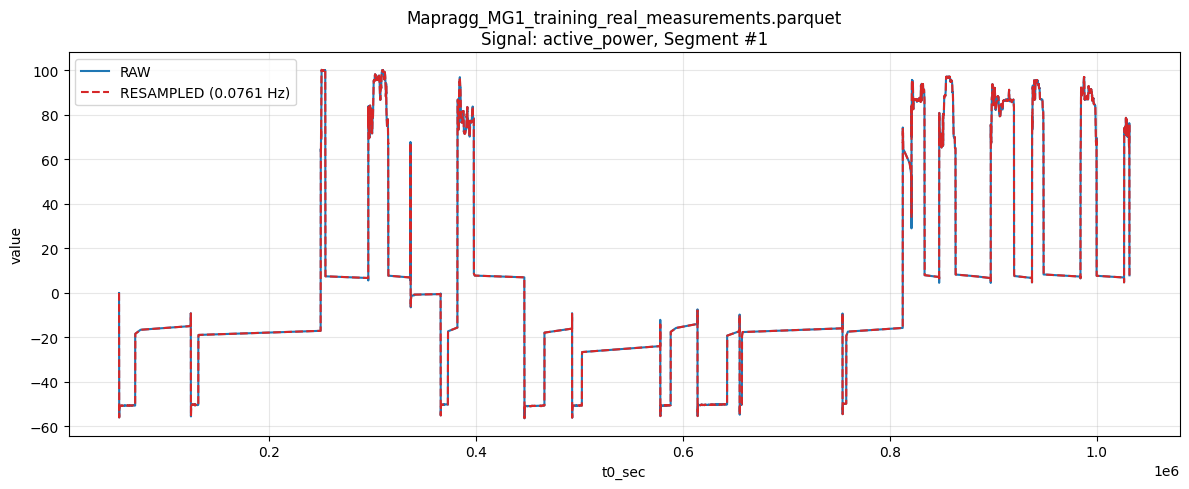

In [20]:
plot_raw_vs_resampled(
    "Mapragg_MG1_training_real_measurements.parquet",
    "active_power",
    1
)


In [21]:
def plot_resampled_segment_with_window(WINDOW_LENGTH=10.0):

    file_dd = widgets.Dropdown(
        options=sorted(all_segments_resampled.keys()),
        description="Parquet",
        layout={"width": "400px"}
    )

    seg_slider = widgets.IntSlider(
        description="Segment",
        min=0, max=0, value=0, step=1,
        continuous_update=False,
        layout={"width": "400px"}
    )

    slider_box = VBox()
    plot_out = Output()

    initializing = {"active": True}

    def viewer(filename, seg_index, window_start):

        if initializing["active"]:
            return

        signals = [
            "active_power",
            "guide_vane_position",
            "water_pressure_downstream",
            "water_pressure_upstream",
            "ball_valve_closed",
            "ball_valve_open",
        ]

        units = {
            "active_power": "[W]",
            "guide_vane_position": "[%]",
            "water_pressure_downstream": "[bar]",
            "water_pressure_upstream": "[bar]",
            "ball_valve_closed": "[-]",
            "ball_valve_open": "[-]",
        }

        colors = [
            "tab:blue", "tab:orange", "tab:green",
            "tab:red", "tab:purple", "tab:brown"
        ]

        segdict = all_segments_resampled[filename]

        t0 = window_start
        t1 = window_start + WINDOW_LENGTH

        fig, axes = plt.subplots(
            len(signals), 1,
            figsize=(12, 2.6 * len(signals)),
            sharex=False          
        )

        for ax, sig, color in zip(axes, signals, colors):

            seg = segdict[sig][seg_index]
            mask = (seg["t0_sec"] >= t0) & (seg["t0_sec"] <= t1)
            seg_win = seg.loc[mask]

            ax.plot(seg_win["t0_sec"], seg_win["value"], color=color)
            ax.set_ylabel(f"{sig.replace('_',' ')} {units[sig]}", fontsize=9)
            ax.set_xlabel("time [s]", fontsize=9)
            ax.grid(True, alpha=0.3)

            xticks = np.linspace(t0, t1, 5)
            ax.set_xticks(xticks)
            ax.set_xticklabels([f"{x:.0f}" for x in xticks], fontsize=8)

        fig.suptitle(
            f"{filename} – Segment {seg_index+1}",
            y=1.02
        )
        plt.tight_layout()
        plt.show()


    def update_seg_slider(*args):
        fname = file_dd.value
        seg_slider.max = len(all_segments_resampled[fname]["active_power"]) - 1
        seg_slider.value = 0

    file_dd.observe(update_seg_slider, names="value")
    update_seg_slider()

    def build_slider(t_min, t_max):
        duration = t_max - t_min

        if duration <= WINDOW_LENGTH:
            return widgets.FloatSlider(
                description="Start time",
                min=t_min, max=t_min, value=t_min,
                continuous_update=False,
                layout={"width": "90%"}
            )

        return widgets.FloatSlider(
            description="Start time",
            min=t_min, max=t_max - WINDOW_LENGTH,
            value=t_min,
            step=WINDOW_LENGTH / 200,
            continuous_update=False,
            layout={"width": "90%"}
        )

    def rebuild_slider(*args):
        fname = file_dd.value
        seg_idx = seg_slider.value
        seg = all_segments_resampled[fname]["active_power"][seg_idx]

        if len(seg) < 2:
            s = widgets.FloatSlider(description="Start time", min=0, max=0, value=0, disabled=True)
            slider_box.children = (s,)
            return

        t_min = float(seg["t0_sec"].min())
        t_max = float(seg["t0_sec"].max())

        if not np.isfinite(t_min) or not np.isfinite(t_max):
            s = widgets.FloatSlider(description="Start time", min=0, max=0, value=0, disabled=True)
            slider_box.children = (s,)
            return

        if t_max <= t_min:
            t_max = t_min + 1e-6

        # Build new slider
        new_slider = build_slider(t_min, t_max)

        # Connect viewer
        out = interactive_output(
            viewer,
            {
                "filename": file_dd,
                "seg_index": seg_slider,
                "window_start": new_slider
            }
        )

        plot_out.clear_output(wait=True)
        with plot_out:
            display(out)

        slider_box.children = (new_slider,)

    file_dd.observe(rebuild_slider, names="value")
    seg_slider.observe(rebuild_slider, names="value")

    rebuild_slider()
    initializing["active"] = False

    display(VBox([file_dd, seg_slider, slider_box, plot_out]))


plot_resampled_segment_with_window(WINDOW_LENGTH=10000.0)


Output()

# Active power segragation into Turbine/Pump/Other


In [22]:
def extract_active_power(df):
    """Extract active power as a time series with datetime index."""
    ap = df[df["signal_name"] == "active_power"][["ts", "value"]].copy()
    if ap.empty:
        raise ValueError("No active_power signal found.")
    
    ap = ap.sort_values("ts").set_index("ts")

    # Ensure monotonic index
    ap = ap[~ap.index.duplicated(keep="first")]
    
    return ap["value"]


def detect_steady_states(
    P,
    roll_sec=60,            # rolling window (sec)
    std_thr=1.0,            # max allowed rolling std for steady state
    min_power=5.0,          # minimum |Power| to be considered "active"
    min_duration=30         # min length of a stable segment (sec)
):
    """
    Detect stable segments in active power signal.
    Returns: list of dicts with start, end, mean_power, classification
    """

    # Determine approximate sampling interval
    dt = P.index.to_series().diff().median().total_seconds()
    if pd.isna(dt) or dt <= 0:
        dt = 1.0

    win = max(1, int(round(roll_sec / dt)))

    # Rolling standard deviation for stability check
    P_std = P.rolling(win, center=True, min_periods=1).std()

    # Condition for steady: low std AND |P| > min_power
    steady_mask = (P_std <= std_thr) & (P.abs() >= min_power)

    # Create segments from steady_mask changes
    segments = []
    seg_id = (steady_mask != steady_mask.shift()).cumsum()

    for _, seg_idx in P.groupby(seg_id):
        idx = seg_idx.index

        # Check steady or not
        is_steady = steady_mask.loc[idx].iloc[0]

        start = idx.min()
        end   = idx.max()
        duration = (end - start).total_seconds()

        if not is_steady:
            continue  # skip non-steady intervals

        if duration < min_duration:
            continue  # too short → ignore

        P_mean = P.loc[idx].mean()

        # classify
        if P_mean > min_power:
            mode = "turbine"
        elif P_mean < -min_power:
            mode = "pump"
        else:
            mode = "other"

        segments.append({
            "start": start,
            "end": end,
            "duration_sec": duration,
            "mean_power": P_mean,
            "mode": mode
        })

    return segments


def classify_modes_in_df(df, **kwargs):
    """
    Adds 'mode' column to full dataframe:
    - turbine
    - pump
    - other
    - transient (everything outside steady segments)
    """
    P = extract_active_power(df)
    segments = detect_steady_states(P, **kwargs)

    # default: everything transient
    df = df.sort_values("ts").copy()
    df["mode"] = "transient"

    # fill steady segments with labels
    for seg in segments:
        mask = (df["ts"] >= seg["start"]) & (df["ts"] <= seg["end"])
        df.loc[mask, "mode"] = seg["mode"]

    return df, segments


In [23]:
df = pd.read_parquet("Mapragg_MG1_training_real_measurements.parquet")
df["ts"] = pd.to_datetime(df["ts"])

df = df.merge(df_mapping, on="signal_id", how="left")

df_modes, steady_segments = classify_modes_in_df(
    df,
    roll_sec=60,
    std_thr=1.0,
    min_power=5.0,
    min_duration=30
)

print("Detected steady segments:")
for seg in steady_segments:
    print(seg)


Detected steady segments:
{'start': Timestamp('2020-06-03 08:52:15.904000+0000', tz='UTC'), 'end': Timestamp('2020-06-03 09:46:40.630000+0000', tz='UTC'), 'duration_sec': 3264.726, 'mean_power': np.float64(76.7876388107521), 'mode': 'turbine'}
{'start': Timestamp('2020-06-03 09:46:48.091000+0000', tz='UTC'), 'end': Timestamp('2020-06-03 10:00:16.813000+0000', tz='UTC'), 'duration_sec': 808.722, 'mean_power': np.float64(78.349120367141), 'mode': 'turbine'}
{'start': Timestamp('2020-06-03 10:00:31.019000+0000', tz='UTC'), 'end': Timestamp('2020-06-03 10:01:15.850000+0000', tz='UTC'), 'duration_sec': 44.831, 'mean_power': np.float64(71.37403945922851), 'mode': 'turbine'}
{'start': Timestamp('2020-06-03 16:54:35.840000+0000', tz='UTC'), 'end': Timestamp('2020-06-03 17:30:22.409000+0000', tz='UTC'), 'duration_sec': 2146.569, 'mean_power': np.float64(69.78574716009895), 'mode': 'turbine'}
{'start': Timestamp('2020-06-03 17:30:51.763000+0000', tz='UTC'), 'end': Timestamp('2020-06-03 18:00:21.

In [24]:
SIGNALS_FOR_CORR = [
    "active_power",
    "guide_vane_position",
    "water_pressure_downstream",
    "water_pressure_upstream",
    "ball_valve_closed", 
    "ball_valve_open",
]

def fix_sarelli_power_sign(df):
    """
    Invert active_power for Sarelli only.
    Applies AFTER merging with df_mapping.
    """

    mask = (df["stage"] == "Sarelli") & (df["signal_name"] == "active_power")
    df.loc[mask, "value"] *= -1
    return df


def extract_active_power(df):
    ap = df[df["signal_name"] == "active_power"][["ts", "value"]].copy()
    if ap.empty:
        raise ValueError("No active_power signal found in df.")

    ap = ap.sort_values("ts").set_index("ts")
    ap = ap[~ap.index.duplicated()]
    return ap["value"]


def detect_steady_states(
    P,
    roll_sec=60,         # rolling window for std
    std_thr=1.0,         # max std allowed for steady-state
    min_power=5.0,       # threshold for turbine/pump differentiation
    min_duration=30      # segment min duration (seconds)
):
    dt = P.index.to_series().diff().median().total_seconds()
    if pd.isna(dt) or dt <= 0:
        dt = 1.0

    win = max(1, int(round(roll_sec / dt)))

    P_std = P.rolling(win, center=True, min_periods=1).std()

    steady_mask = (P_std <= std_thr) & (P.abs() >= min_power)

    segments = []
    seg_id = (steady_mask != steady_mask.shift()).cumsum()

    for _, seg in P.groupby(seg_id):
        idx = seg.index
        is_steady = steady_mask.loc[idx].iloc[0]

        if not is_steady:
            continue

        start = idx.min()
        end = idx.max()
        duration = (end - start).total_seconds()
        if duration < min_duration:
            continue

        P_mean = P.loc[idx].mean()

        # classification
        if P_mean >= min_power:
            mode = "turbine"
        elif P_mean <= -min_power:
            mode = "pump"
        else:
            mode = "other"

        segments.append({
            "start": start,
            "end": end,
            "duration": duration,
            "mean_power": P_mean,
            "mode": mode
        })

    return segments

def classify_modes_in_df(df, **kwargs):
    df = df.sort_values("ts").copy()
    df["mode"] = "transient"

    P = extract_active_power(df)
    steady_segments = detect_steady_states(P, **kwargs)

    for seg in steady_segments:
        mask = (df["ts"] >= seg["start"]) & (df["ts"] <= seg["end"])
        df.loc[mask, "mode"] = seg["mode"]

    return df, steady_segments


def split_into_mode_segments(df_modes):
    df_modes = df_modes.sort_values("ts").copy()
    seg_id = (df_modes["mode"] != df_modes["mode"].shift()).cumsum()

    mode_segments = []

    for _, segdf in df_modes.groupby(seg_id):
        mode = segdf["mode"].iloc[0]
        if mode == "transient":
            continue

        mode_segments.append({
            "mode": mode,
            "df": segdf.copy(),
            "start": segdf["ts"].min(),
            "end": segdf["ts"].max()
        })

    return mode_segments

def make_wide(seg_df, signals=SIGNALS_FOR_CORR):
    """
    Convert long-format segment into wide format for selected signals.
    index = ts, columns = signal_name, values = value
    """
    seg_df = seg_df[seg_df["signal_name"].isin(signals)]
    if seg_df.empty:
        return None

    pivot = seg_df.pivot_table(
        index="ts",
        columns="signal_name",
        values="value",
        aggfunc="mean",
    ).sort_index()

    # forward/backward fill in time
    pivot = pivot.ffill().bfill()

    # drop columns with no variance -> corr would be NaN
    var = pivot.var()
    pivot = pivot.loc[:, var > 0]

    if pivot.shape[1] < 2:
        return None  # not enough varying signals to correlate

    return pivot


def segment_correlation(seg_df, signals=SIGNALS_FOR_CORR):
    """
    Compute full correlation matrix for the given segment.
    Uses make_wide() to ensure consistent signal coverage.
    Guarantees full matrix and diagonal=1.
    """
    wide = make_wide(seg_df, signals=signals)
    if wide is None:
        return None

    # Compute correlation
    C = wide.corr()

    # Reindex to ensure all required signals appear
    C = C.reindex(index=signals, columns=signals)

    # Replace diagonal with 1.0
    np.fill_diagonal(C.values, 1.0)

    return C

def aggregate_corrs(corr_list, signals=SIGNALS_FOR_CORR):
    """
    Aggregate a list of correlation DataFrames using NaN-aware mean.
    Returns a DataFrame with index/columns = signals.
    """
    if not corr_list:
        return None

    mats = []
    for C in corr_list:
        if C is None:
            continue

        C2 = C.reindex(index=signals, columns=signals)
        mats.append(C2.to_numpy(dtype=float))

    if not mats:
        return None

    arr = np.stack(mats, axis=0)          
    m = np.nanmean(arr, axis=0)            

    return pd.DataFrame(m, index=signals, columns=signals)


def process_parquet(path, df_mapping,
                    roll_sec=60, std_thr=1.0,
                    min_power=5.0, min_duration=30):

    print(f"\n=== Processing {path} ===")

    df = pd.read_parquet(path)
    df["ts"] = pd.to_datetime(df["ts"], utc=False)


    df = df.merge(df_mapping, on="signal_id", how="left")


    df = fix_sarelli_power_sign(df)

    df_modes, steady_segments = classify_modes_in_df(
        df,
        roll_sec=roll_sec,
        std_thr=std_thr,
        min_power=min_power,
        min_duration=min_duration
    )

    print(f"Detected {len(steady_segments)} steady segments.")

    # Segment per mode (steady only)
    mode_segments = split_into_mode_segments(df_modes)

    turbine_corrs = []
    pump_corrs = []
    other_corrs = []

    for seg in mode_segments:
        C = segment_correlation(seg["df"], signals=SIGNALS_FOR_CORR)
        if C is None:
            continue

        if seg["mode"] == "turbine":
            turbine_corrs.append(C)
        elif seg["mode"] == "pump":
            pump_corrs.append(C)
        else:
            other_corrs.append(C)

    agg_turbine = aggregate_corrs(turbine_corrs, signals=SIGNALS_FOR_CORR)
    agg_pump    = aggregate_corrs(pump_corrs,    signals=SIGNALS_FOR_CORR)
    agg_other   = aggregate_corrs(other_corrs,   signals=SIGNALS_FOR_CORR)


    mask_rest = ~df_modes["mode"].isin(["turbine", "pump"])
    if mask_rest.any():
        rest_df = df_modes[mask_rest]
        corr_rest = segment_correlation(rest_df, signals=SIGNALS_FOR_CORR)
    else:
        corr_rest = None

    return {
        "file": path,
        "df_modes": df_modes,
        "segments": mode_segments,
        "corr_turbine": agg_turbine,
        "corr_pump": agg_pump,
        "corr_other": agg_other,
        "corr_rest": corr_rest,  
    }


In [25]:
def plot_mode_corr_heatmaps(result_dict):
    file = result_dict["file"]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # TURBINE
    if result_dict["corr_turbine"] is not None:
        sns.heatmap(result_dict["corr_turbine"], vmin=-1, vmax=1,
                    cmap="coolwarm", ax=axes[0])
        axes[0].set_title(f"{file}\nTURBINE correlation")
    else:
        axes[0].set_title("No turbine steady-state segments")

    # PUMP
    if result_dict["corr_pump"] is not None:
        sns.heatmap(result_dict["corr_pump"], vmin=-1, vmax=1,
                    cmap="coolwarm", ax=axes[1])
        axes[1].set_title(f"{file}\nPUMP correlation")
    else:
        axes[1].set_title("No pump steady-state segments")

    # REMAINING (NOT TURBINE / NOT PUMP)
    if result_dict.get("corr_rest") is not None:
        sns.heatmap(result_dict["corr_rest"], vmin=-1, vmax=1,
                    cmap="coolwarm", ax=axes[2])
        axes[2].set_title(f"{file}\n TRANSIENT STATE correlation")
    else:
        axes[2].set_title("No remaining data for correlation")

    plt.tight_layout()
    plt.show()



=== Processing Mapragg_MG1_testing_real_measurements.parquet ===


Detected 701 steady segments.


/var/folders/t4/57x32m1x0z57n3k9h907l2580000gn/T/ipykernel_48281/2698346231.py:188: RuntimeWarning: Mean of empty slice
  m = np.nanmean(arr, axis=0)


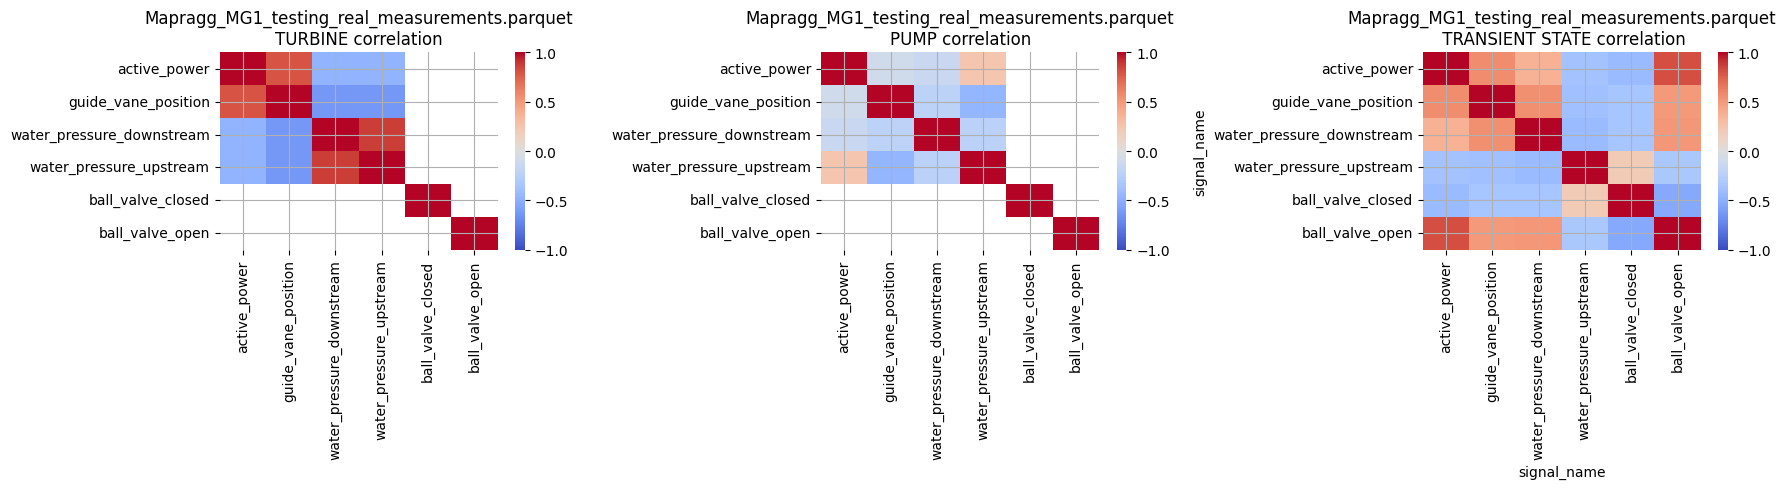


=== Processing Mapragg_MG1_training_real_measurements.parquet ===
Detected 2552 steady segments.


/var/folders/t4/57x32m1x0z57n3k9h907l2580000gn/T/ipykernel_48281/2698346231.py:188: RuntimeWarning: Mean of empty slice
  m = np.nanmean(arr, axis=0)


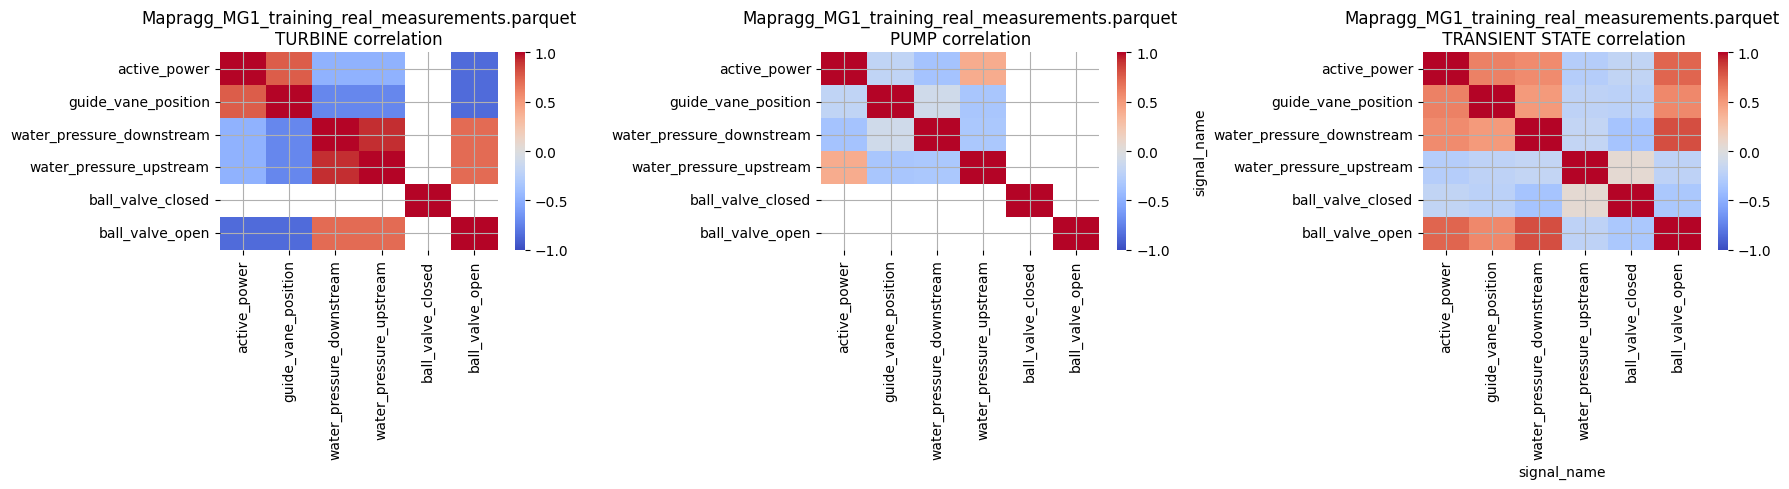


=== Processing Mapragg_MG2_testing_real_measurements.parquet ===
Detected 471 steady segments.


/var/folders/t4/57x32m1x0z57n3k9h907l2580000gn/T/ipykernel_48281/2698346231.py:188: RuntimeWarning: Mean of empty slice
  m = np.nanmean(arr, axis=0)


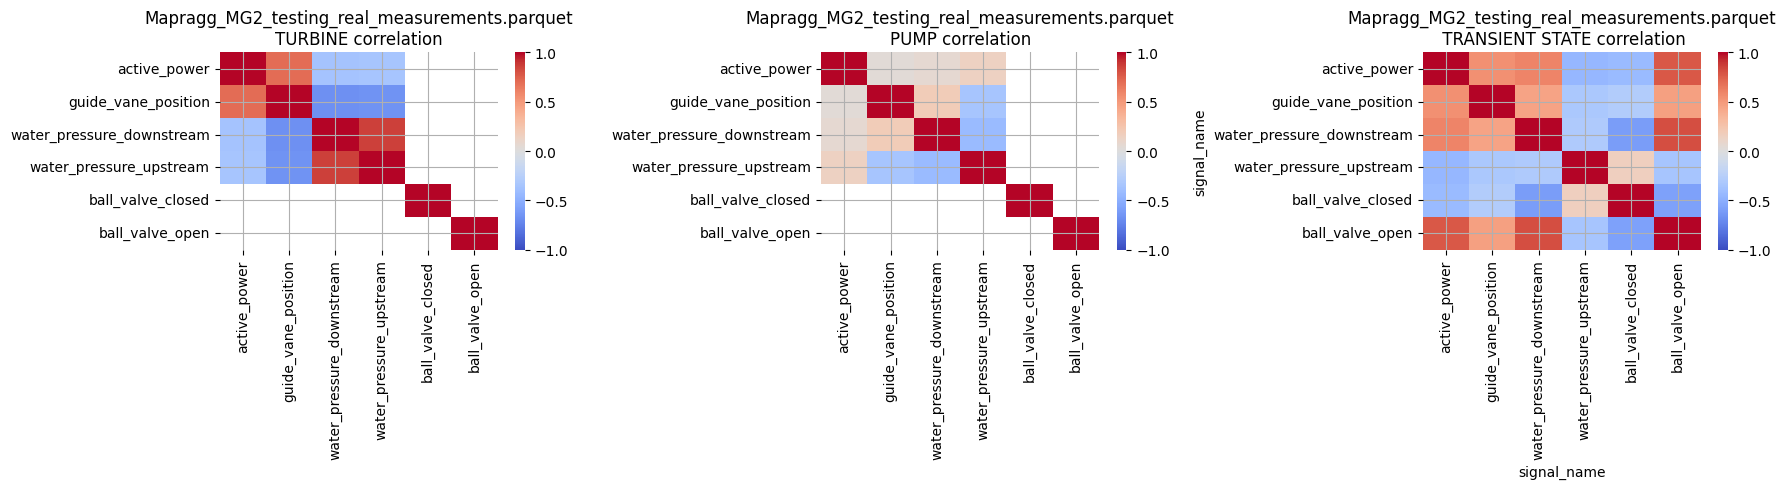


=== Processing Mapragg_MG2_training_real_measurements.parquet ===
Detected 5484 steady segments.


/var/folders/t4/57x32m1x0z57n3k9h907l2580000gn/T/ipykernel_48281/2698346231.py:188: RuntimeWarning: Mean of empty slice
  m = np.nanmean(arr, axis=0)


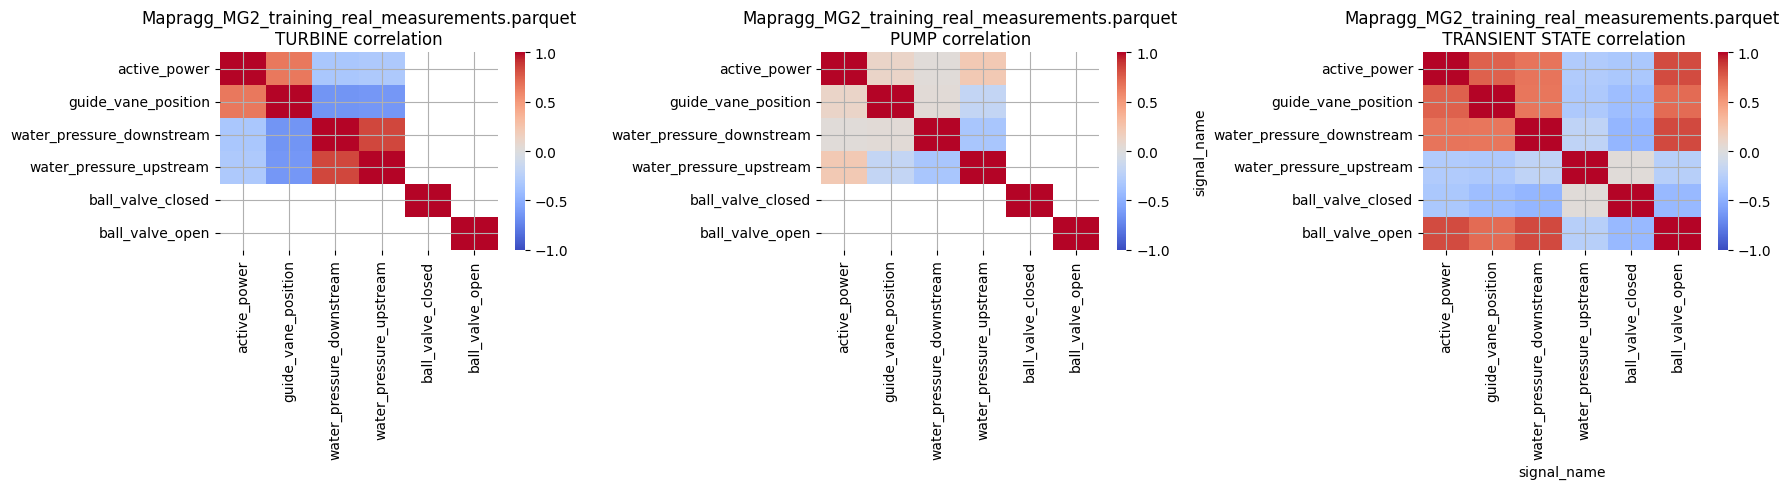


=== Processing Mapragg_MG3_testing_real_measurements.parquet ===
Detected 673 steady segments.


/var/folders/t4/57x32m1x0z57n3k9h907l2580000gn/T/ipykernel_48281/2698346231.py:188: RuntimeWarning: Mean of empty slice
  m = np.nanmean(arr, axis=0)


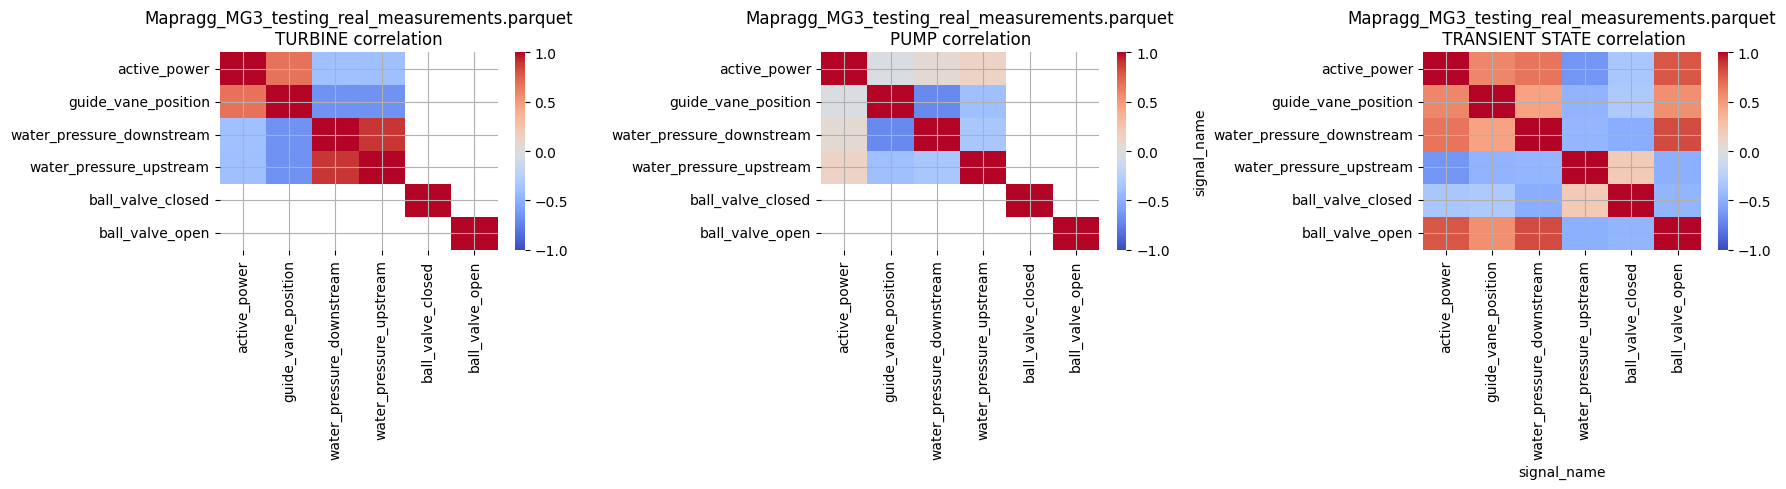


=== Processing Mapragg_MG3_training_real_measurements.parquet ===
Detected 2763 steady segments.


/var/folders/t4/57x32m1x0z57n3k9h907l2580000gn/T/ipykernel_48281/2698346231.py:188: RuntimeWarning: Mean of empty slice
  m = np.nanmean(arr, axis=0)


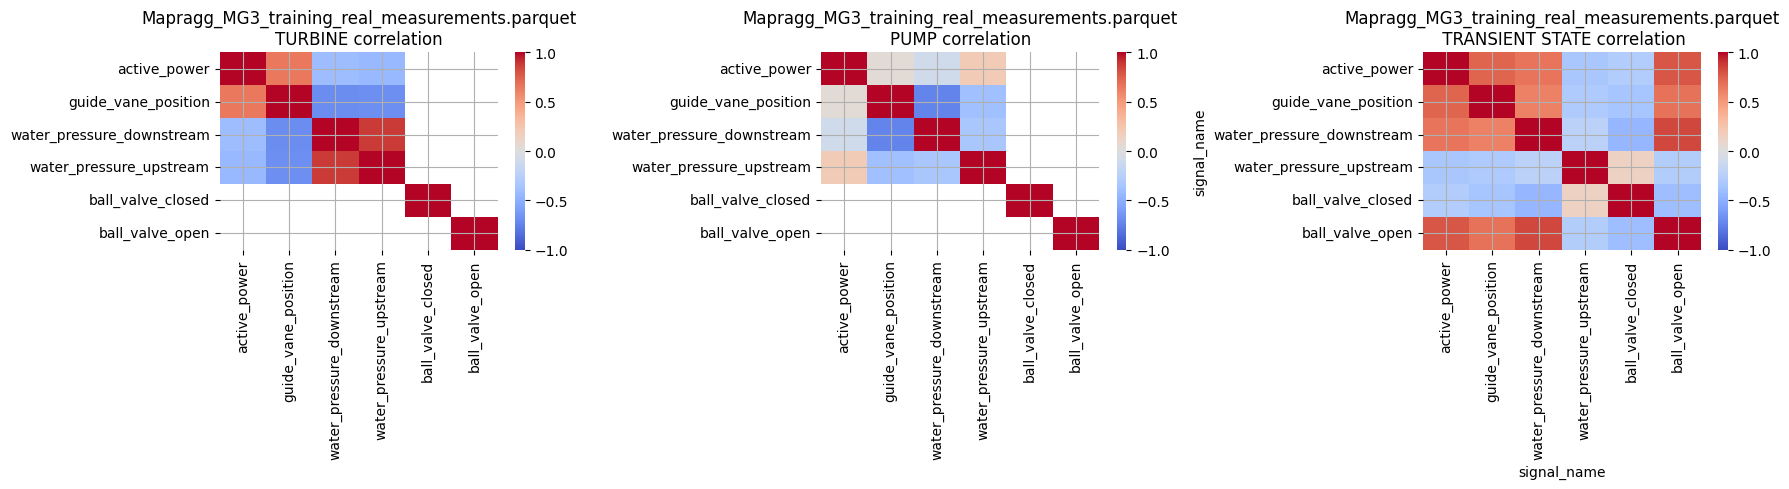


=== Processing Sarelli_MG1_testing_real_measurements.parquet ===
Detected 132 steady segments.


/var/folders/t4/57x32m1x0z57n3k9h907l2580000gn/T/ipykernel_48281/2698346231.py:188: RuntimeWarning: Mean of empty slice
  m = np.nanmean(arr, axis=0)


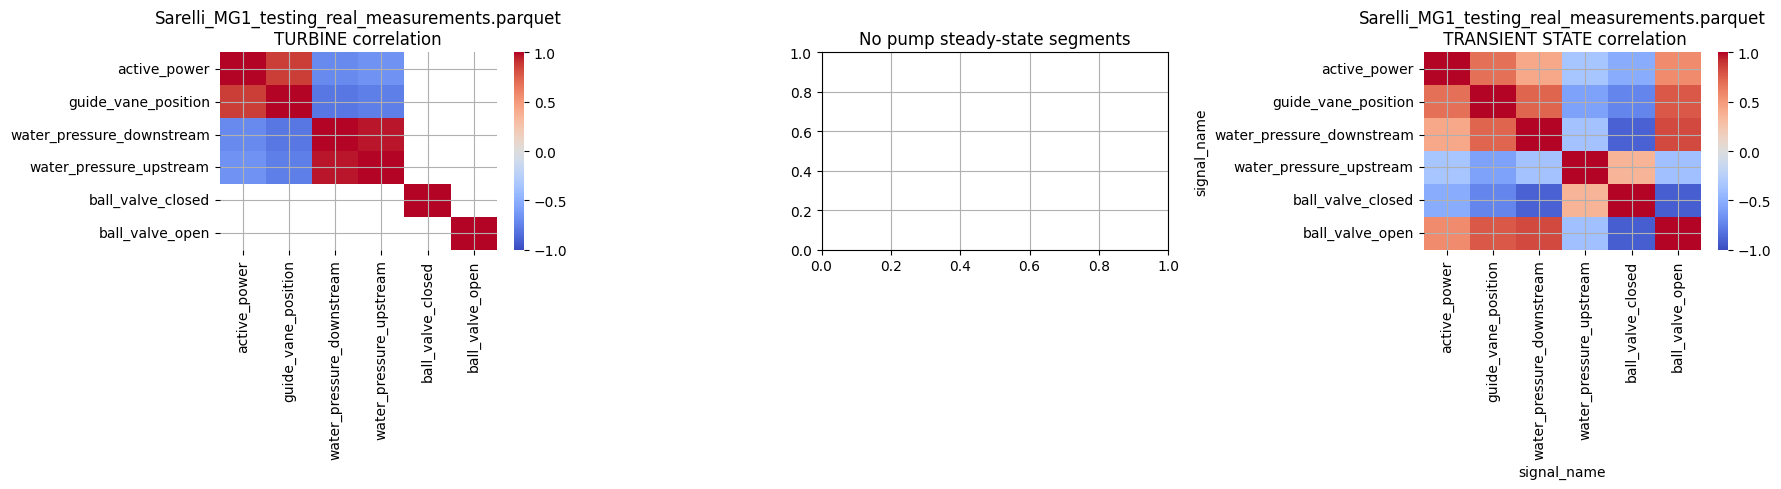


=== Processing Sarelli_MG1_training_real_measurements.parquet ===
Detected 422 steady segments.


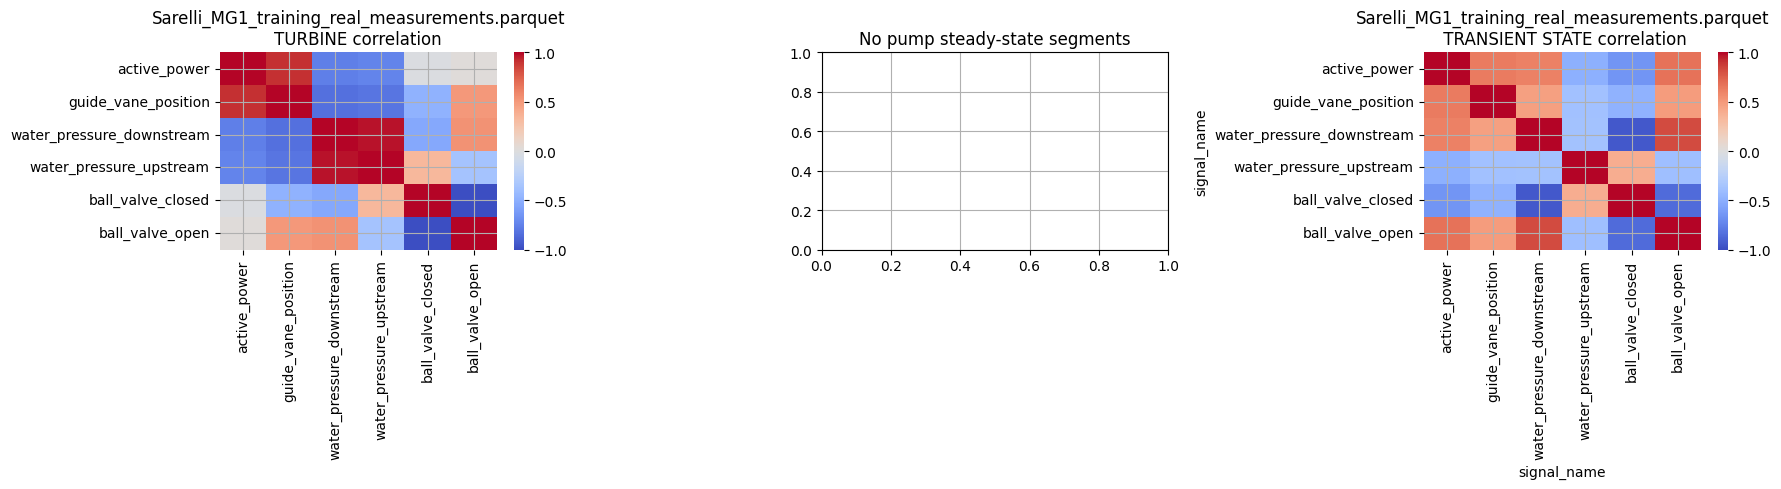


=== Processing Sarelli_MG2_testing_real_measurements.parquet ===
Detected 203 steady segments.


/var/folders/t4/57x32m1x0z57n3k9h907l2580000gn/T/ipykernel_48281/2698346231.py:188: RuntimeWarning: Mean of empty slice
  m = np.nanmean(arr, axis=0)


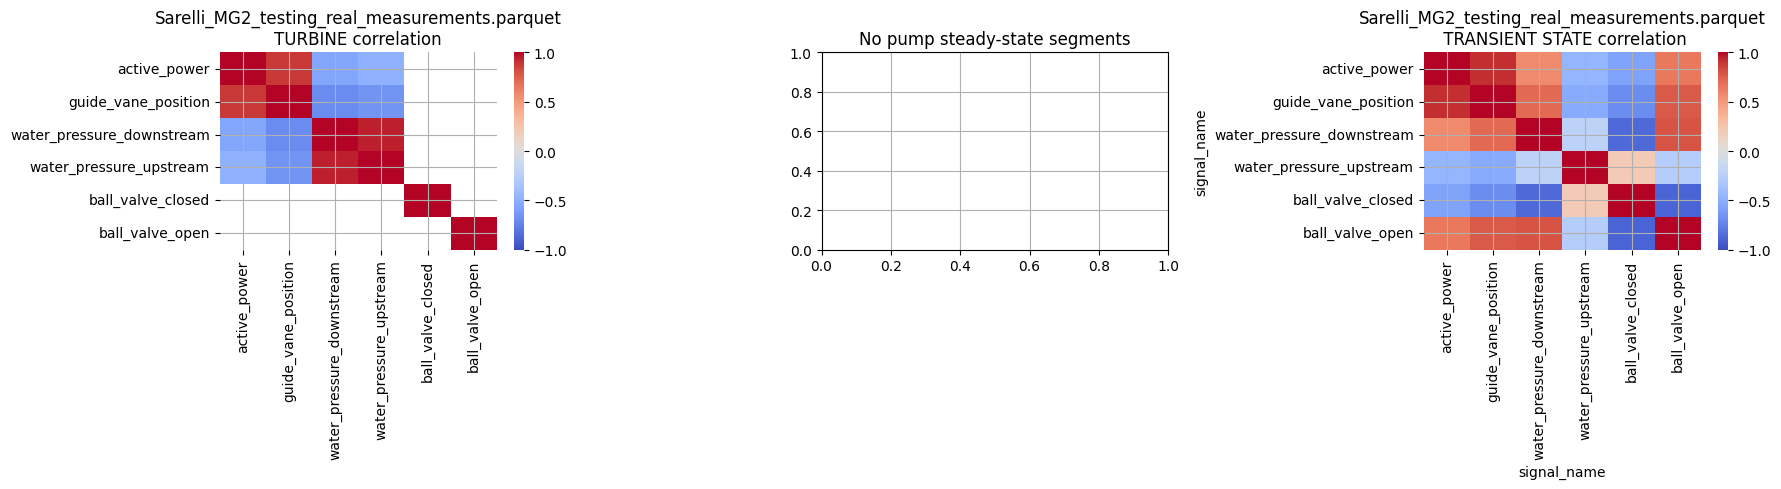


=== Processing Sarelli_MG2_training_real_measurements.parquet ===
Detected 934 steady segments.


/var/folders/t4/57x32m1x0z57n3k9h907l2580000gn/T/ipykernel_48281/2698346231.py:188: RuntimeWarning: Mean of empty slice
  m = np.nanmean(arr, axis=0)


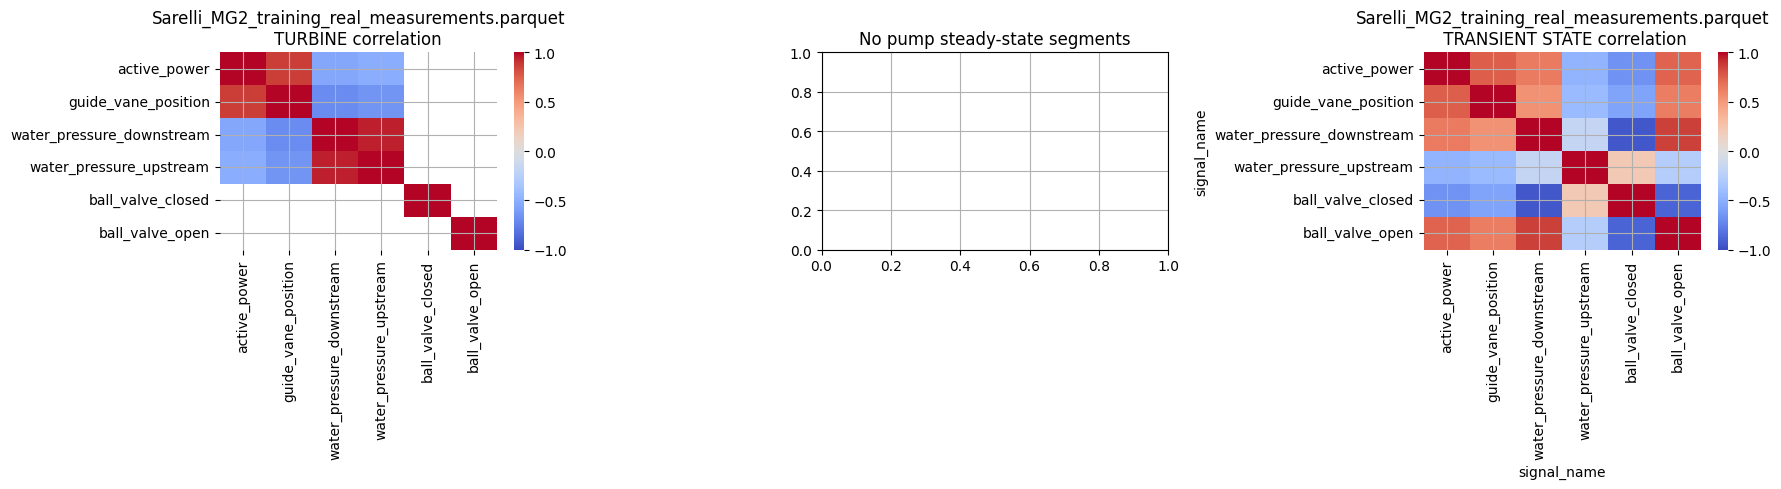

In [26]:
results = {}

for path in parquet_files:
    res = process_parquet(path, df_mapping)
    results[path] = res
    plot_mode_corr_heatmaps(res)


In [27]:
# The signals you want to analyze:
SIGNALS_FOR_DIST = [
    "active_power",
    "guide_vane_position",
    "water_pressure_downstream",
    "water_pressure_upstream",
    "ball_valve_closed",
    "ball_valve_open",
]

def extract_resampled_distributions(all_segments_resampled):
    """
    Returns a nested structure:
    distributions[station][dataset_type][signal] = describe()
    """

    distributions = {"Mapragg": {}, "Sarelli": {}}

    for parquet_name, entry in all_segments_resampled.items():
        
        station = entry["stage"]        # "Mapragg" or "Sarelli"
        dtype   = entry["dataset_type"] # "training" or "testing"

        if dtype not in distributions[station]:
            distributions[station][dtype] = {}

        # Loop over signals
        for sig in SIGNALS_FOR_DIST:
            seglist = entry[sig] if sig in entry else None
            if seglist is None:
                continue

            # Combine all resampled segments for this parquet + signal
            df_combined = pd.concat(seglist, ignore_index=True)

            if sig not in distributions[station][dtype]:
                distributions[station][dtype][sig] = [df_combined["value"]]
            else:
                distributions[station][dtype][sig].append(df_combined["value"])

    # Convert lists of arrays → descriptive statistics
    for station in distributions:
        for dtype in distributions[station]:
            for sig in distributions[station][dtype]:
                values = pd.concat(distributions[station][dtype][sig], ignore_index=True)
                distributions[station][dtype][sig] = values.describe(percentiles=[0.05, 0.5, 0.95])

    return distributions


resampled_dists = extract_resampled_distributions(all_segments_resampled)

print("=== Mapragg — Training ===")
print(resampled_dists["Mapragg"]["training"])

print("\n=== Mapragg — Testing ===")
print(resampled_dists["Mapragg"]["testing"])

print("\n=== Sarelli — Training ===")
print(resampled_dists["Sarelli"]["training"])

print("\n=== Sarelli — Testing ===")
print(resampled_dists["Sarelli"]["testing"])


=== Mapragg — Training ===
{'active_power': count    6.037082e+06
mean     1.101003e+00
std      4.178224e+01
min     -6.070358e+01
5%      -5.155593e+01
50%     -7.296253e-01
95%      9.217306e+01
max      1.173420e+02
Name: value, dtype: float64, 'guide_vane_position': count    6.372748e+06
mean     2.717989e+01
std      3.963860e+01
min      0.000000e+00
5%       7.276895e-02
50%      6.666378e-01
95%      9.984548e+01
max      9.999726e+01
Name: value, dtype: float64, 'water_pressure_downstream': count    6.374345e+06
mean     6.602784e+00
std      1.596515e+01
min     -1.337714e+00
5%      -1.162263e+00
50%      1.433193e-01
95%      4.549170e+01
max      5.006855e+01
Name: value, dtype: float64, 'water_pressure_upstream': count    6.375086e+06
mean     4.669184e+01
std      1.966175e+00
min      3.643536e-01
5%       4.303295e+01
50%      4.731643e+01
95%      4.880642e+01
max      5.038498e+01
Name: value, dtype: float64, 'ball_valve_closed': count    6.047872e+06
mean     8.370

In [28]:
def plot_resampled_histograms(all_segments_resampled, bins=80):

    # Mapping from signal_name → nice title + x-axis label
    LABELS = {
        "active_power": ("Active power", "Active power [MW]"),
        "guide_vane_position": ("Guide vane position", "Guide vane position [%]"),
        "water_pressure_downstream": ("Downward water pressure", "Downward water pressure [bar]"),
        "water_pressure_upstream": ("Upward water pressure", "Upward water pressure [bar]"),
        "ball_valve_closed": ("Ball valve closed", "Ball valve closed [-]"),
        "ball_valve_open": ("Ball valve open", "Ball valve open [-]"),
    }

    colors = {"training": "steelblue", "testing": "firebrick"}

    for station in ["Mapragg", "Sarelli"]:

        # Collect data grouped by dataset type
        grouped = {"training": {}, "testing": {}}

        for parquet_name, entry in all_segments_resampled.items():
            if entry["stage"] != station:
                continue

            dtype = entry["dataset_type"]

            # gather per-signal resampled values
            for sig in SIGNALS_FOR_DIST:
                seglist = entry.get(sig, [])
                if not seglist:
                    continue
                df_sig = pd.concat(seglist, ignore_index=True)

                if sig not in grouped[dtype]:
                    grouped[dtype][sig] = [df_sig["value"]]
                else:
                    grouped[dtype][sig].append(df_sig["value"])

        # --- Create 3×2 grid ---
        fig, axes = plt.subplots(3, 2, figsize=(14, 12))
        fig.suptitle(f"{station} — Resampled Signal Distributions", fontsize=18)

        axes = axes.flatten()

        for ax, sig in zip(axes, SIGNALS_FOR_DIST):

            # Plot training/testing histograms
            for dtype in ["training", "testing"]:
                if sig not in grouped[dtype]:
                    continue

                vals = pd.concat(grouped[dtype][sig], ignore_index=True)

                ax.hist(vals, bins=bins, alpha=0.6,
                        color=colors[dtype], label=dtype)

            title, xlabel = LABELS[sig]
            ax.set_title(title)
            ax.set_xlabel(xlabel)
            ax.set_ylabel("Count")
            ax.legend()

        # Clear any empty unused subplots (if any)
        for ax in axes[len(SIGNALS_FOR_DIST):]:
            ax.axis("off")

        plt.tight_layout()
        plt.show()


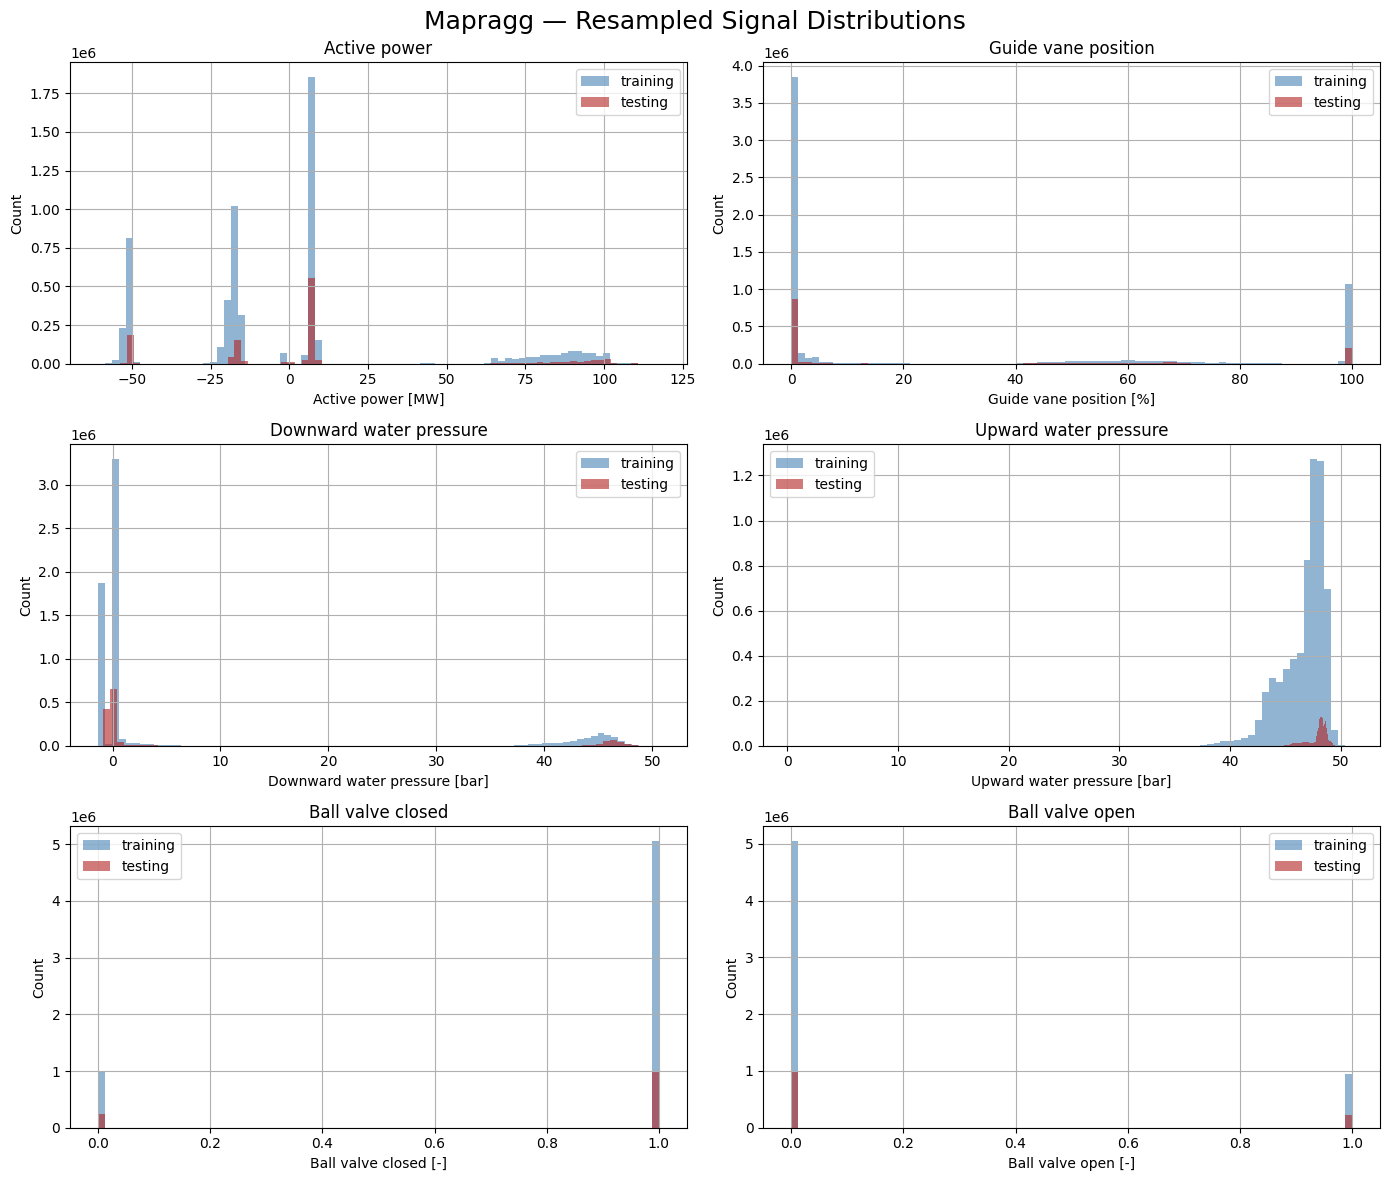

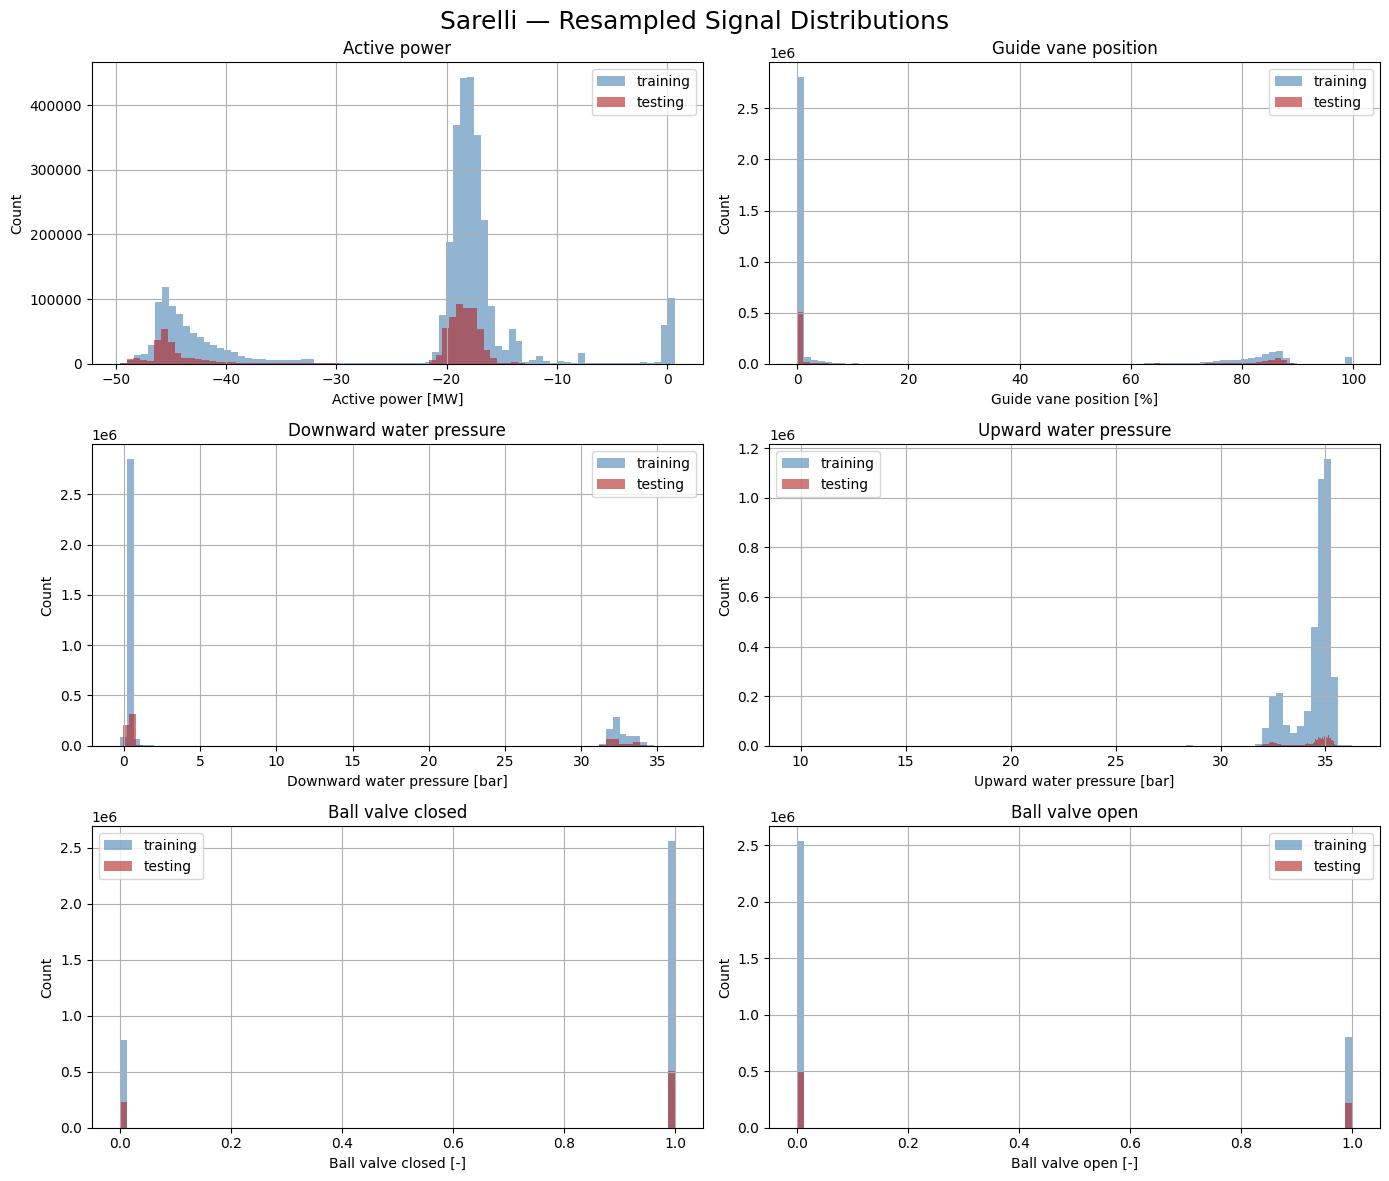

In [29]:
plot_resampled_histograms(all_segments_resampled)


# Task 1


In [30]:
def segment_to_joint_df(segdict, seg_idx):

    def extract(sig):
        return segdict[sig][seg_idx][["t0_sec", "value"]].rename(columns={"value": sig})

    dfP    = extract("active_power")
    dfGV   = extract("guide_vane_position")
    dfDown = extract("water_pressure_downstream")
    dfUp   = extract("water_pressure_upstream")
    dfClose = extract("ball_valve_closed")
    dfOpen = extract("ball_valve_open")

    df = (
        dfP.merge(dfGV, on="t0_sec", how="outer")
           .merge(dfDown, on="t0_sec", how="outer")
           .merge(dfUp, on="t0_sec", how="outer")
           .merge(dfClose, on="t0_sec", how="outer")
           .merge(dfOpen, on="t0_sec", how="outer")
           .sort_values("t0_sec")
           .reset_index(drop=True)
    )

    df = df.ffill().bfill()

    df = df.rename(columns={
        "active_power": "P",
        "guide_vane_position": "GV",
        "water_pressure_downstream": "P_down",
        "water_pressure_upstream": "P_up",
        "ball_valve_closed": "closed",
        "ball_valve_open": "open",
    })

    return df


def detect_valve_motion(df,
                        window_sec=1.0,
                        k=10,
                        pd_stable_window=2.0,
                        pd_stable_thresh=15.0):

    t = df["t0_sec"].values
    dt = np.median(np.diff(t))
    win = max(int(window_sec / dt), 10)

    S1 = df["P"].rolling(win, center=True).std()
    S2 = df["GV"].rolling(win, center=True).std()
    S3 = df["P_up"].rolling(win, center=True).std()
    S4 = df["P_down"].rolling(win, center=True).std()

    score = 0.3*S1 + 0.3*S2 + 0.3*S3 + 0.1*S4

    med = score.median()
    mad = (score - med).abs().median()
    threshold = med + k*mad

    movement = score > threshold

    # downstream stability suppression
    w2 = max(int(pd_stable_window / dt), 50)

    down_max = df["P_down"].rolling(w2, center=True).max()
    down_min = df["P_down"].rolling(w2, center=True).min()
    down_range = down_max - down_min

    pd_inactive = down_range < pd_stable_thresh
    movement = movement & (~pd_inactive)

    return movement, score, threshold



def extract_motion_events(movement, t):
    movement = movement.values if hasattr(movement, "values") else movement
    t = np.asarray(t)

    events = []
    inside = False
    start = None

    for i in range(len(movement)):
        if movement[i] and not inside:
            inside = True
            start = t[i]
        if not movement[i] and inside:
            inside = False
            events.append((start, t[i]))

    if inside:
        events.append((start, t[-1]))

    return events


def detect_valve_events_in_parquet(
        parquet_name,
        all_segments_resampled,
        buffer=100.0,
        margin_start=300.0,     # ignore events starting within this distance from segment start
        margin_end=1200.0,       # ignore events starting within this distance from segment end
        min_separation=300.0
    ):

    results = {}
    segdict = all_segments_resampled[parquet_name]

    n_seg = len(segdict["active_power"])
    print(f"Running valve-motion detection on {parquet_name} ({n_seg} segments)\n")

    for seg_idx in range(n_seg):
        df = segment_to_joint_df(segdict, seg_idx)
        movement, score, thr = detect_valve_motion(df)

        # raw ON/OFF events
        raw_events = extract_motion_events(movement, df["t0_sec"])

        seg_start = df["t0_sec"].iloc[0]
        seg_end   = df["t0_sec"].iloc[-1]

        raw_events = [(s,e) for (s,e) in raw_events if e < seg_end]

        # sort
        raw_events = sorted(raw_events, key=lambda x: x[0])


        merged = []
        if raw_events:
            cur_s, cur_e = raw_events[0]
            for (s, e) in raw_events[1:]:
                if s - cur_e < min_separation:
                    cur_e = max(cur_e, e)
                else:
                    merged.append((cur_s, cur_e))
                    cur_s, cur_e = s, e
            merged.append((cur_s, cur_e))
        raw_events = merged
        

        raw_events = [(s, min(e, seg_end)) for (s, e) in raw_events]

        print(f"  Before boundary filtering: {len(raw_events)} events")
        filtered_events = []
        for (s, e) in raw_events:
            dist_start_from_seg_start = s - seg_start
            dist_end_from_seg_end = seg_end - e
            
            if s < seg_start + margin_start:
                continue
            
            if s > seg_end - margin_end:
                continue
            
            if e > seg_end:
                continue
            
            if e < seg_start + margin_start:
                continue

            
            filtered_events.append((s, e))
        
        raw_events = filtered_events

        cleaned_events = [(s - buffer, e + buffer) for (s, e) in raw_events]

        # store
        results[seg_idx] = {
            "cleaned_events": cleaned_events,
            "threshold": float(thr),
        }

    return results

In [31]:
def plot_resampled_segment_with_window_and_valve(WINDOW_LENGTH=2000.0):

    file_dd = widgets.Dropdown(
        options=sorted(all_segments_resampled.keys()),
        description="Parquet",
        layout={"width": "400px"}
    )

    seg_slider = widgets.IntSlider(
        description="Segment",
        min=0, max=0, value=0, step=1,
        continuous_update=False,
        layout={"width": "400px"}
    )

    slider_box = VBox()
    plot_out = Output(layout={"width": "100%"})
    initializing = {"active": True}

    signals = [
        "active_power",
        "guide_vane_position",
        "water_pressure_downstream",
        "water_pressure_upstream",
        "ball_valve_closed",
        "ball_valve_open",
    ]

    units = {
        "active_power": "Active power [MW]",
        "guide_vane_position": "Guide vane position [%]",
        "water_pressure_downstream": "Downstream pressure [bar]",
        "water_pressure_upstream": "Upstream pressure [bar]",
        "ball_valve_closed": "Ball valve closed [-]",
        "ball_valve_open": "Ball valve open [-]",
    }

    colors = [
        "tab:blue", "tab:orange", "tab:green",
        "tab:red", "tab:purple", "tab:brown"
    ]

    def viewer(filename, seg_index, window_start):

        if initializing["active"]:
            return

        segdict = all_segments_resampled[filename]
        seg = segdict["active_power"][seg_index]
        seg_start = seg["t0_sec"].min()
        seg_end = seg["t0_sec"].max()

        window_end = window_start + WINDOW_LENGTH

        cleaned = valve_detection_results[filename][seg_index]["cleaned_events"]

        fig, axes = plt.subplots(
            len(signals), 1,
            figsize=(18, 3 * len(signals)),
            dpi=120,
            sharex=False
        )

        for ax, sig, color in zip(axes, signals, colors):
            seg_data = segdict[sig][seg_index]

            ax.plot(seg_data["t0_sec"], seg_data["value"], color=color)
            ax.set_ylabel(units[sig], fontsize=9)
            ax.grid(True, alpha=0.3)

            for (ts, te) in cleaned:
                ax.axvspan(ts, te, color="red", alpha=0.20)

            ax.axvline(seg_start, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
            ax.axvline(seg_end, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

            ax.set_xlim(window_start, window_end)

            y_vals = seg_data["value"].values
            y_min, y_max = y_vals.min(), y_vals.max()
            y_range = y_max - y_min
            padding = y_range * 0.1 if y_range > 0 else abs(y_min) * 0.05
            ax.set_ylim(y_min - padding, y_max + padding)

            xticks = np.linspace(window_start, window_end, 5)
            ax.set_xticks(xticks)
            ax.set_xticklabels([f"{x:.0f}" for x in xticks], fontsize=8)

        fig.suptitle(f"{filename} – Segment {seg_index+1}", y=1.02)
        plt.tight_layout()
        plt.show()

    def update_seg_slider(*args):
        fname = file_dd.value
        seg_slider.max = len(all_segments_resampled[fname]["active_power"]) - 1
        seg_slider.value = 0

    file_dd.observe(update_seg_slider, names="value")
    update_seg_slider()

    def build_slider(t_min, t_max):
        return widgets.FloatSlider(
            description="Window start",
            min=t_min,
            max=t_max - WINDOW_LENGTH,
            value=t_min,
            continuous_update=False,
            layout={"width": "90%"}
        )

    def rebuild_slider(*args):
        fname = file_dd.value
        seg_idx = seg_slider.value
        seg = all_segments_resampled[fname]["active_power"][seg_idx]

        if len(seg) < 2:
            s = widgets.FloatSlider(description="Window start", min=0, max=0, value=0, disabled=True)
            slider_box.children = (s,)
            return

        t_min = float(seg["t0_sec"].min())
        t_max = float(seg["t0_sec"].max())

        new_slider = build_slider(t_min, t_max)

        out = interactive_output(
            viewer,
            {
                "filename": file_dd,
                "seg_index": seg_slider,
                "window_start": new_slider
            }
        )

        plot_out.clear_output(wait=True)
        with plot_out:
            display(out)

        slider_box.children = (new_slider,)

    file_dd.observe(rebuild_slider, names="value")
    seg_slider.observe(rebuild_slider, names="value")

    rebuild_slider()
    initializing["active"] = False

    display(VBox([file_dd, seg_slider, slider_box, plot_out], layout={"width": "100%"}))


valve_detection_results = {}
for parquet_name in all_segments_resampled.keys():
    valve_detection_results[parquet_name] = detect_valve_events_in_parquet(
        parquet_name, 
        all_segments_resampled,
        margin_start=300.0,
        margin_end=600.0,
    )

plot_resampled_segment_with_window_and_valve(WINDOW_LENGTH=160000.0)


Running valve-motion detection on Mapragg_MG1_testing_real_measurements.parquet (3 segments)

  Before boundary filtering: 86 events
  Before boundary filtering: 85 events
  Before boundary filtering: 10 events
Running valve-motion detection on Mapragg_MG1_training_real_measurements.parquet (16 segments)

  Before boundary filtering: 9 events
  Before boundary filtering: 30 events
  Before boundary filtering: 49 events
  Before boundary filtering: 46 events
  Before boundary filtering: 17 events
  Before boundary filtering: 74 events
  Before boundary filtering: 93 events
  Before boundary filtering: 109 events
  Before boundary filtering: 64 events
  Before boundary filtering: 62 events
  Before boundary filtering: 63 events
  Before boundary filtering: 47 events
  Before boundary filtering: 91 events
  Before boundary filtering: 85 events
  Before boundary filtering: 116 events
  Before boundary filtering: 17 events
Running valve-motion detection on Mapragg_MG2_testing_real_measureme

Output()

# Task1: TCN for closing and opening time determination


In [32]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(22)
torch.manual_seed(22)

INPUT_SIGNALS = [
    "active_power",
    "guide_vane_position",
    "water_pressure_downstream",
    "water_pressure_upstream",
]

LABEL_OPEN   = "ball_valve_open"
LABEL_CLOSED = "ball_valve_closed"

N_SAMPLES = 384
PAD_FRAC = 0.3
BATCH_SIZE = 64

all_parquets = sorted(valve_detection_results.keys())
for i, p in enumerate(all_parquets):
    print(f"  {i}: {p}")

data_split_dict = {}

for parquet_name in all_parquets:
    lower_name = parquet_name.lower()
    
    if 'train' in lower_name:
        data_split_dict[parquet_name] = 'train'
    elif 'test' in lower_name:
        data_split_dict[parquet_name] = 'test'
    else:
        data_split_dict[parquet_name] = 'train'
        print(f"  WARNING: Could not determine split for '{parquet_name}', assuming 'train'")

train_count = sum(1 for v in data_split_dict.values() if v == 'train')
test_count = sum(1 for v in data_split_dict.values() if v == 'test')

if test_count == 0:
    print("\n⚠️  WARNING: No test files detected!")
    print("  If you have test data, please manually specify data_split_dict above.")

if train_count == 0:
    raise ValueError("No training files found! Please check data_split_dict configuration.")


def collect_events(valve_detection_results, data_split_dict, split='train'):
    events = []
    files_used = []
    
    for parquet_name in sorted(valve_detection_results.keys()):
        if data_split_dict.get(parquet_name) != split:
            continue
        
        files_used.append(parquet_name)
        
        for seg_idx, seg_dict in valve_detection_results[parquet_name].items():
            for evt_idx, (ts, te) in enumerate(seg_dict.get("cleaned_events", [])):
                events.append({
                    "parquet": parquet_name,
                    "segment": seg_idx,
                    "ts": float(ts),
                    "te": float(te),
                })
    
    print(f"\n{split.upper()} split uses {len(files_used)} files:")
    for f in files_used:
        print(f"  - {f}")
    
    return events

events_train = collect_events(valve_detection_results, data_split_dict, split='train')
print("Total training events:", len(events_train))

events = events_train
print("Using all training events:", len(events))


def sample_step(tsrc, vsrc, t_grid):
    idx = np.searchsorted(tsrc, t_grid, side="right") - 1
    idx = np.clip(idx, 0, len(tsrc)-1)
    return vsrc[idx]


def extract_window(parquet, seg_idx, ts, te, n_samples=N_SAMPLES):
    seg = all_segments_resampled[parquet]

    # segment time boundaries
    df_ref = seg["active_power"][seg_idx]
    tmin_seg, tmax_seg = df_ref["t0_sec"].min(), df_ref["t0_sec"].max()

    dur = max(te-ts, 1e-6)
    t0 = max(tmin_seg, ts - PAD_FRAC * dur)
    t1 = min(tmax_seg, te + PAD_FRAC * dur)
    if t1 <= t0:
        return None, None, None

    t_grid = np.linspace(t0, t1, n_samples)

    # ---- features ----
    X = []
    for sig in INPUT_SIGNALS:
        df = seg[sig][seg_idx]
        t = df["t0_sec"].values
        v = df["value"].values
        v_interp = np.interp(t_grid, t, v)
        X.append(v_interp)
    X = np.stack(X, axis=-1).astype(np.float32)

    # ---- labels open / closed ----
    df_o = seg[LABEL_OPEN][seg_idx]
    df_c = seg[LABEL_CLOSED][seg_idx]

    o = sample_step(df_o["t0_sec"].values, df_o["value"].values, t_grid)
    c = sample_step(df_c["t0_sec"].values, df_c["value"].values, t_grid)

    y = np.stack([(o>0.5).astype(np.float32),
                  (c>0.5).astype(np.float32)], axis=-1)

    # skip events with no change
    if y.min() == y.max():
        return None, None, None

    return t_grid, X, y


X_list, y_list = [], []
skipped = 0

for ev in events:
    t_grid, X, y = extract_window(ev["parquet"], ev["segment"], ev["ts"], ev["te"])
    if X is None:
        skipped += 1
        continue
    X_list.append(X)
    y_list.append(y)

print(f"Extracted {len(X_list)} windows, skipped {skipped}")

X_raw = np.stack(X_list, axis=0)     # (N,T,C)
y_raw = np.stack(y_list, axis=0)     # (N,T,2)

print("Dataset:", X_raw.shape, y_raw.shape)

# normalize inputs using ONLY training data statistics
channel_mean = X_raw.mean((0,1), keepdims=True)
channel_std  = X_raw.std((0,1), keepdims=True) + 1e-6
X_norm = (X_raw - channel_mean) / channel_std

print(f"Normalization: mean shape {channel_mean.shape}, std shape {channel_std.shape}")


# pytorch dataset
class ValveTCNDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]


# Split training data into train/val (80/20)
idx = np.arange(len(X_norm))
np.random.shuffle(idx)
n_train = int(0.8*len(idx))

train_ds = ValveTCNDataset(X_norm[idx[:n_train]], y_raw[idx[:n_train]])
val_ds   = ValveTCNDataset(X_norm[idx[n_train:]], y_raw[idx[n_train:]])

print(f"Training samples: {len(train_ds)}, Validation samples: {len(val_ds)}")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE)


class Chomp1d(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.size = size
    def forward(self, x):  
        return x[:, :, :-self.size]


class TemporalBlock(nn.Module):
    def __init__(self, nin, nout, k=7, d=1, dropout=0.2):
        super().__init__()
        pad = (k-1)*d

        self.conv1 = nn.Conv1d(nin, nout, k, padding=pad, dilation=d)
        self.chomp1 = Chomp1d(pad)
        self.bn1 = nn.BatchNorm1d(nout)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(nout, nout, k, padding=pad, dilation=d)
        self.chomp2 = Chomp1d(pad)
        self.bn2 = nn.BatchNorm1d(nout)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.down = nn.Conv1d(nin, nout, 1) if nin != nout else None

    def forward(self, x):
        out = self.conv1(x)
        out = self.chomp1(out)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out = self.conv2(out)
        out = self.chomp2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        
        res = x if self.down is None else self.down(x)
        return out + res


class TCN_2Head(nn.Module):
    def __init__(self, in_ch=4, hidden=[64, 128, 128], k=7, dropout=0.2):
        super().__init__()
        # Input normalization layer
        self.input_norm = nn.BatchNorm1d(in_ch)
        
        layers = []
        for i,h in enumerate(hidden):
            nin = in_ch if i==0 else hidden[i-1]
            d = 2**i
            layers.append(TemporalBlock(nin, h, k=k, d=d, dropout=dropout))
        self.tcn = nn.Sequential(*layers)
        self.head = nn.Conv1d(hidden[-1], 2, 1)  # outputs: open, closed

    def forward(self, x):
        x = x.transpose(1,2)          # (B,T,C)->(B,C,T)
        x = self.input_norm(x)        # Normalize inputs
        feat = self.tcn(x)
        return self.head(feat)        # (B,2,T)


model = TCN_2Head(in_ch=len(INPUT_SIGNALS), dropout=0.2).to(DEVICE)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

# Print model info
n_params = sum(p.numel() for p in model.parameters())
print(f"\nModel created with {n_params:,} parameters")
print(f"Architecture: {[64, 128, 128]}, Kernel: 7, Dropout: 0.2")


def evaluate(loader):
    model.eval()
    total = 0
    with torch.no_grad():
        for X, y in loader:
            X = X.to(DEVICE)
            y = y.to(DEVICE).transpose(1,2)  # (B,2,T)
            loss = criterion(model(X), y)
            total += loss.item()
    return total / len(loader)


print("\nStarting training (50 epochs)...")
print("="*70)

best_val_loss = float('inf')
patience_counter = 0
patience = 8

for epoch in range(1, 51):  
    model.train()
    losses = []

    for X, y in train_loader:
        X = X.to(DEVICE)
        y = y.to(DEVICE).transpose(1,2)

        optim.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optim.step()

        losses.append(loss.item())

    train_loss = np.mean(losses)
    val_loss = evaluate(val_loader)
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        patience_counter = 0
        # Save best model
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
    
    # Print with early stopping indicator
    status = "" if val_loss == best_val_loss else f"({patience_counter}/{patience})"
    print(f"Epoch {epoch:02d} | train={train_loss:.4f} | val={val_loss:.4f} {status}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch}")
        print(f"Best validation loss: {best_val_loss:.4f} at epoch {best_epoch}")
        # Restore best model
        model.load_state_dict(best_model_state)
        break

print("\n" + "="*70)
print("TRAINING COMPLETE!")
print("="*70)
print(f"\nBest Results:")
print(f"  Best Validation Loss: {best_val_loss:.4f}")
print(f"  Achieved at Epoch: {best_epoch}")
print(f"\nModel Features:")
print(f"  - Batch Normalization: ✓ (input + after each conv)")
print(f"  - Dropout: ✓ (0.2 rate)")
print(f"  - Early Stopping: ✓ (patience={patience})")
print(f"  - Total Parameters: {n_params:,}")

print("\nIMPORTANT: For inference on test data, use these normalization parameters:")
print(f"  channel_mean shape: {channel_mean.shape}")
print(f"  channel_std shape: {channel_std.shape}")
print("\nTo save the model:")
print("""
torch.save({
    'model_state_dict': model.state_dict(),
    'channel_mean': channel_mean,
    'channel_std': channel_std,
    'best_val_loss': best_val_loss,
    'hyperparameters': {
        'hidden': [64, 128, 128],
        'kernel_size': 7,
        'dropout': 0.2,
        'n_samples': N_SAMPLES,
        'pad_frac': PAD_FRAC
    }
}
""")
print("="*70)

  0: Mapragg_MG1_testing_real_measurements.parquet
  1: Mapragg_MG1_training_real_measurements.parquet
  2: Mapragg_MG2_testing_real_measurements.parquet
  3: Mapragg_MG2_training_real_measurements.parquet
  4: Mapragg_MG3_testing_real_measurements.parquet
  5: Mapragg_MG3_training_real_measurements.parquet
  6: Sarelli_MG1_testing_real_measurements.parquet
  7: Sarelli_MG1_training_real_measurements.parquet
  8: Sarelli_MG2_testing_real_measurements.parquet
  9: Sarelli_MG2_training_real_measurements.parquet

TRAIN split uses 5 files:
  - Mapragg_MG1_training_real_measurements.parquet
  - Mapragg_MG2_training_real_measurements.parquet
  - Mapragg_MG3_training_real_measurements.parquet
  - Sarelli_MG1_training_real_measurements.parquet
  - Sarelli_MG2_training_real_measurements.parquet
Total training events: 4083
Using all training events: 4083
Extracted 4070 windows, skipped 13
Dataset: (4070, 384, 4) (4070, 384, 2)
Normalization: mean shape (1, 1, 4), std shape (1, 1, 4)
Training sam

In [33]:
MIN_TRANSITION_TIME = 20  
MAX_TRANSITION_TIME = 65  

MEDIAN_FILTER_SIZE = 7 

THRESHOLDS_SINGLE_EVENT = (0.15, 0.85)  
THRESHOLDS_MULTI_EVENT = (0.35, 0.75)   


def find_steepest_transitions(prob, low_thr=0.20, high_thr=0.80,
                              min_len=3, min_delta=0.15, deriv_window=5,
                              context_window=50):
    """
    More sensitive transition detector with smoothed input.
    """

    # smooth for derivative only
    if len(prob) < 7:
        prob_smooth = prob.copy()
    else:
        win = min(11, len(prob) // 2 * 2 + 1)
        prob_smooth = savgol_filter(prob, window_length=win, polyorder=2)

    deriv = np.gradient(prob_smooth)

    prob = np.asarray(prob)
    n = len(prob)

    mid_mask = (prob > low_thr) & (prob < high_thr)
    idx = np.where(mid_mask)[0]

    rising_transitions = []
    falling_transitions = []

    if len(idx) == 0:
        return rising_transitions, falling_transitions

    starts = [idx[0]]
    ends = []
    for i in range(1, len(idx)):
        if idx[i] != idx[i-1] + 1:
            ends.append(idx[i-1])
            starts.append(idx[i])
    ends.append(idx[-1])

    for s, e in zip(starts, ends):
        if e - s + 1 < min_len:
            continue

        delta = prob[e] - prob[s]
        if abs(delta) < min_delta:
            continue

        if delta > 0:
            direction = "up"
        else:
            direction = "down"

        check_start = max(0, s - 20)
        check_end = min(n, e + 20)
        prob_window = prob[check_start:check_end]
        range_span = np.max(prob_window) - np.min(prob_window)
        
        if range_span < 0.4:
            continue
        
        if direction == "up":
            if np.max(prob_window) - prob[s] < 0.3:
                continue
        else:
            if prob[s] - np.min(prob_window) < 0.3:
                continue

        context_start = max(0, s - context_window)
        context_end = min(n, e + context_window)
        
        has_low_before  = np.any(prob[context_start:s] < low_thr)
        has_high_before = np.any(prob[context_start:s] > high_thr)
        has_low_after   = np.any(prob[e+1:context_end] < low_thr)
        has_high_after  = np.any(prob[e+1:context_end] > high_thr)

        if direction == "up":
            if not (has_low_before or has_high_after):
                continue
        else:
            if not (has_high_before or has_low_after):
                continue

        search_start = s
        search_end = e
        
        while search_start > 0 and search_start > s - 50:
            if direction == "up":
                if prob[search_start - 1] < 0.05:
                    break
            else:
                if prob[search_start - 1] > 0.95:
                    break
            search_start -= 1
        
        while search_end < n - 1 and search_end < e + 50:
            if direction == "up":
                if prob[search_end + 1] > 0.95:
                    break
            else:
                if prob[search_end + 1] < 0.05:
                    break
            search_end += 1
        
        search_slice = slice(search_start, search_end + 1)
        d_search = deriv[search_slice]
        
        if direction == "up":
            k_rel = int(np.argmax(d_search))
        else:
            k_rel = int(np.argmin(d_search))
        
        center_idx = search_start + k_rel

        fs = max(0, center_idx - deriv_window)
        fe = min(n, center_idx + deriv_window + 1)
        if fe - fs < 3:
            continue

        X_fit = np.arange(fs, fe).reshape(-1, 1)
        y_fit = prob[fs:fe]

        reg = LinearRegression()
        reg.fit(X_fit, y_fit)

        m = reg.coef_[0]
        b = reg.intercept_
        if abs(m) < 1e-4:
            continue

        # Store raw slope parameters - will compute x_at_0/x_at_1 later based on event count
        trans = {
            "center": center_idx,
            "slope": m,
            "intercept": b,
        }

        if direction == "up":
            rising_transitions.append(trans)
        else:
            falling_transitions.append(trans)

    return rising_transitions, falling_transitions


def apply_adaptive_thresholds(transitions, num_events_expected):

    if num_events_expected == 1:
        thresh_low, thresh_high = THRESHOLDS_SINGLE_EVENT
    else:
        thresh_low, thresh_high = THRESHOLDS_MULTI_EVENT
    
    for trans in transitions:
        m = trans['slope']
        b = trans['intercept']
        
        x_at_0 = (thresh_low - b) / m
        x_at_1 = (thresh_high - b) / m
        
        trans['x_at_0'] = x_at_0
        trans['x_at_1'] = x_at_1
        trans['thresh_low'] = thresh_low
        trans['thresh_high'] = thresh_high
    
    return transitions


def estimate_event_count(all_transitions):

    falling_count = sum(1 for t in all_transitions if t['type'] == 'falling')
    rising_count = sum(1 for t in all_transitions if t['type'] == 'rising')
    
    # Conservative estimate: min of falling and rising counts
    estimated_events = min(falling_count, rising_count)
    
    return max(1, estimated_events)


def find_measured_transitions(t, x):

    x = np.asarray(x)
    t = np.asarray(t)

    leaves_0 = []
    arrives_0 = []

    zero_mask = (x == 0)
    if not np.any(zero_mask):
        return leaves_0, arrives_0
    
    changes = np.diff(np.concatenate([[False], zero_mask, [False]]).astype(int))
    starts = np.where(changes == 1)[0]
    ends = np.where(changes == -1)[0]
    
    for start, end in zip(starts, ends):
        arrives_0.append(t[start])
        leaves_0.append(t[end-1])

    return leaves_0, arrives_0


def compare_tcn_measured(tcn_durations, meas_durations, max_pair_offset=10):
    """Pairs TCN and measured events by closest duration and computes errors."""
    if not tcn_durations or not meas_durations:
        return None

    pairs = []
    used = set()

    for tcn in tcn_durations:
        diffs = [abs(tcn - m) if i not in used else np.inf
                 for i, m in enumerate(meas_durations)]
        idx = int(np.argmin(diffs))
        if diffs[idx] <= max_pair_offset:
            pairs.append((tcn, meas_durations[idx]))
            used.add(idx)

    if not pairs:
        return None

    errors = np.array([tcn - meas for tcn, meas in pairs])

    return {
        "n": len(errors),
        "mean_error": errors.mean(),
        "median_error": np.median(errors),
        "mae": np.mean(np.abs(errors)),
        "max_abs_error": np.max(np.abs(errors)),
        "errors": errors,
    }


def infer_slopes_tcn(model, parquet, seg_idx, ts, te):
    """Robust transition detector with SMOOTHING applied before detection."""

    res = extract_window(parquet, seg_idx, ts, te)
    if res is None:
        return None

    t, X, _ = res
    Xn = (X - channel_mean.squeeze()) / channel_std.squeeze()
    Xn = torch.tensor(Xn, dtype=torch.float32).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits = model(Xn)[0].cpu().numpy()

    p_open   = 1/(1+np.exp(-logits[0]))
    p_closed = 1/(1+np.exp(-logits[1]))

    p_open_smooth = median_filter(p_open, size=MEDIAN_FILTER_SIZE)
    p_closed_smooth = median_filter(p_closed, size=MEDIAN_FILTER_SIZE)

    # Detect transitions on SMOOTHED signals (without x_at_0/x_at_1 yet)
    open_rising, open_falling = find_steepest_transitions(p_open_smooth)
    closed_rising, closed_falling = find_steepest_transitions(p_closed_smooth)

    return {
        "t": t,
        "p_open": p_open,
        "p_closed": p_closed,
        "p_open_smooth": p_open_smooth,
        "p_closed_smooth": p_closed_smooth,
        "open_rising": open_rising,
        "open_falling": open_falling,
        "closed_rising": closed_rising,
        "closed_falling": closed_falling,
    }

def pair_transitions_to_events(all_transitions, min_time, max_time):
    
    events_grouped = []
    events_rejected = []
    
    i = 0
    while i < len(all_transitions):
        current = all_transitions[i]
        
        if current['type'] == 'falling':
            last_falling_idx = i
            j = i + 1
            while j < len(all_transitions) and all_transitions[j]['type'] == 'falling':
                last_falling_idx = j
                j += 1
            
            rising_idx = None
            k = last_falling_idx + 1
            while k < len(all_transitions):
                if all_transitions[k]['type'] == 'rising':
                    rising_idx = k
                    break
                k += 1
            
            if rising_idx is not None:
                falling_trans = all_transitions[last_falling_idx]
                rising_trans = all_transitions[rising_idx]
                
                event_start = max(falling_trans['time_0'], falling_trans['time_1'])
                event_end = min(rising_trans['time_0'], rising_trans['time_1'])
                transition_duration = event_end - event_start
                
                if MIN_TRANSITION_TIME <= transition_duration <= MAX_TRANSITION_TIME:
                    events_grouped.append({
                        'start': event_start, 
                        'end': event_end,
                        'duration': transition_duration,
                        'accepted': True,
                        'falling_idx': last_falling_idx,
                        'rising_idx': rising_idx
                    })
                else:
                    reason = 'too_short' if transition_duration < MIN_TRANSITION_TIME else 'too_long'
                    events_rejected.append({
                        'start': event_start, 
                        'end': event_end,
                        'duration': transition_duration,
                        'accepted': False,
                        'reason': reason
                    })
                
                i = rising_idx + 1
            else:
                i += 1
        else:
            i += 1
    
    return events_grouped, events_rejected


def plot_valve_events_last_3_plots(
    valve_detection_results,
    all_segments_resampled,
    model,
):

    events = []
    for parquet in sorted(valve_detection_results.keys()):
        segs = valve_detection_results[parquet]
        for seg_idx, seg_dict in segs.items():
            for (ts, te) in seg_dict.get("cleaned_events", []):
                events.append((parquet, seg_idx, ts, te))

    if not events:
        print("No events detected.")
        return

    global_tcn_durations = []
    global_measured_durations = []

    slider = widgets.IntSlider(
        min=0, max=len(events)-1, value=0, step=1,
        description="Event",
        continuous_update=False,
        layout={"width":"600px"}
    )

    info = widgets.HTML()
    out = Output()

    signals = [
        "ball_valve_open",
        "ball_valve_closed",
    ]

    units = {
        "ball_valve_open": "Ball valve open [-]",
        "ball_valve_closed": "Ball valve closed [-]",
    }

    colors = [
        "tab:purple","tab:brown"
    ]

    def viewer(idx):
        out.clear_output(wait=True)
        with out:
            parquet, seg_idx, ts, te = events[idx]
            info.value = f"<b>{parquet}</b> – segment {seg_idx+1} – event {idx+1}/{len(events)}"

            res = infer_slopes_tcn(model, parquet, seg_idx, ts, te)
            if res is None:
                print("No TCN result.")
                return

            t = res["t"]
            p_open = res["p_open"]
            p_closed = res["p_closed"]
            p_open_smooth = res["p_open_smooth"]
            p_closed_smooth = res["p_closed_smooth"]

            fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

            pad = 0.15 * (te - ts)
            tmin = ts - pad
            tmax = te + pad

            # Plot valve signals
            for ax, sig, col in zip(axes[:-1], signals, colors):
                df = all_segments_resampled[parquet][sig][seg_idx]
                mask = (df["t0_sec"] >= tmin) & (df["t0_sec"] <= tmax)
                dfw = df.loc[mask]

                ax.plot(dfw["t0_sec"], dfw["value"], color=col, lw=1.1)
                ax.grid(True, alpha=0.3)
                ax.set_ylabel(units[sig], fontsize=9)

            df_open = all_segments_resampled[parquet]["ball_valve_open"][seg_idx]
            df_closed = all_segments_resampled[parquet]["ball_valve_closed"][seg_idx]

            mask_open = (df_open["t0_sec"] >= tmin) & (df_open["t0_sec"] <= tmax)
            mask_closed = (df_closed["t0_sec"] >= tmin) & (df_closed["t0_sec"] <= tmax)

            t_meas_open = df_open.loc[mask_open, "t0_sec"].values
            open_meas = df_open.loc[mask_open, "value"].values
            
            t_meas_closed = df_closed.loc[mask_closed, "t0_sec"].values
            closed_meas = df_closed.loc[mask_closed, "value"].values

            open_leaves_0, open_arrives_0 = find_measured_transitions(t_meas_open, open_meas)
            closed_leaves_0, closed_arrives_0 = find_measured_transitions(t_meas_closed, closed_meas)

            edge_margin = (tmax - tmin) * 0.05
            
            open_arrives_0_filtered = [t for t in open_arrives_0 if tmin + edge_margin < t < tmax - edge_margin]
            open_leaves_0_filtered = [t for t in open_leaves_0 if tmin + edge_margin < t < tmax - edge_margin]
            closed_arrives_0_filtered = [t for t in closed_arrives_0 if tmin + edge_margin < t < tmax - edge_margin]
            closed_leaves_0_filtered = [t for t in closed_leaves_0 if tmin + edge_margin < t < tmax - edge_margin]
            
            valve_axes = [axes[0], axes[1]]
            
            for t_time in open_arrives_0_filtered:
                axes[0].axvline(t_time, color='darkred', linestyle='-', alpha=0.8, linewidth=2.5, zorder=12)
            for t_time in open_leaves_0_filtered:
                axes[0].axvline(t_time, color='darkred', linestyle='-', alpha=0.8, linewidth=2.5, zorder=12)
            
            for t_time in closed_arrives_0_filtered:
                axes[1].axvline(t_time, color='darkred', linestyle='-', alpha=0.8, linewidth=2.5, zorder=12)
            for t_time in closed_leaves_0_filtered:
                axes[1].axvline(t_time, color='darkred', linestyle='-', alpha=0.8, linewidth=2.5, zorder=12)
            
            all_filtered_lines = sorted(open_arrives_0_filtered + open_leaves_0_filtered + 
                                       closed_arrives_0_filtered + closed_leaves_0_filtered)
            
            measured_events_vis = []
            
            i = 0
            while i < len(all_filtered_lines) - 1:
                t_start = all_filtered_lines[i]
                t_end = all_filtered_lines[i + 1]
                duration = t_end - t_start
                
                is_accepted = MIN_TRANSITION_TIME <= duration <= MAX_TRANSITION_TIME
                
                measured_events_vis.append({
                    'start': t_start,
                    'end': t_end,
                    'duration': duration,
                    'accepted': is_accepted
                })
                
                i += 2
            
            meas_ok_filtered = [e['duration'] for e in measured_events_vis if e['accepted']]
            
            for event in measured_events_vis:
                if event['accepted']:
                    for ax in valve_axes:
                        ax.axvspan(event['start'], event['end'], 
                                  color='red', alpha=0.3, zorder=11)
                        
                        mid_time = (event['start'] + event['end']) / 2
                        ax.text(mid_time, ax.get_ylim()[1] * 0.90, 
                               f"Meas: {event['duration']:.1f}s",
                               ha='center', va='top', fontsize=9,
                               bbox=dict(boxstyle='round,pad=0.3', 
                                        facecolor='red', alpha=0.6),
                               zorder=13)

            axp = axes[-1]
            
            axp.plot(t, p_open, "b-", label="p_open (original)", linewidth=1.5, alpha=0.4)
            axp.plot(t, p_closed, "r--", label="p_closed (original)", linewidth=1.5, alpha=0.4)
            axp.plot(t, p_open_smooth, "b-", label=f"p_open (smoothed, {MEDIAN_FILTER_SIZE})", linewidth=2.5, alpha=0.9)
            axp.plot(t, p_closed_smooth, "r--", label=f"p_closed (smoothed, {MEDIAN_FILTER_SIZE})", linewidth=2.5, alpha=0.9)
            
            axp.axhline(0.15, color="gray", linestyle=":", alpha=0.4)
            axp.axhline(0.85, color="gray", linestyle=":", alpha=0.4)
            axp.axhline(0.5, color="gray", linestyle="-.", alpha=0.3, linewidth=1)

            # STEP 1: Build preliminary transition list (without x_at_0/x_at_1)
            all_transitions_prelim = []
            
            for trans in res["open_rising"]:
                all_transitions_prelim.append({
                    'type': 'rising',
                    'signal': 'open',
                    'trans': trans
                })
            
            for trans in res["closed_rising"]:
                all_transitions_prelim.append({
                    'type': 'rising',
                    'signal': 'closed',
                    'trans': trans
                })
            
            for trans in res["open_falling"]:
                all_transitions_prelim.append({
                    'type': 'falling',
                    'signal': 'open',
                    'trans': trans
                })
            
            for trans in res["closed_falling"]:
                all_transitions_prelim.append({
                    'type': 'falling',
                    'signal': 'closed',
                    'trans': trans
                })
            
            # STEP 2: Estimate event count
            num_events = estimate_event_count(all_transitions_prelim)
            
            # STEP 3: Apply adaptive thresholds
            apply_adaptive_thresholds(res["open_rising"], num_events)
            apply_adaptive_thresholds(res["open_falling"], num_events)
            apply_adaptive_thresholds(res["closed_rising"], num_events)
            apply_adaptive_thresholds(res["closed_falling"], num_events)
            
            thresh_used = THRESHOLDS_SINGLE_EVENT if num_events == 1 else THRESHOLDS_MULTI_EVENT
            
            print(f"\n{'='*60}")
            print(f"ADAPTIVE THRESHOLDS")
            print(f"{'='*60}")
            print(f"Estimated events in window: {num_events}")
            print(f"Using thresholds: {thresh_used}")
            print(f"{'='*60}")
            
            # STEP 4: Build full transition list with computed x_at_0/x_at_1
            all_transitions = []
            
            for trans in res["open_rising"]:
                t_at_0 = np.interp(trans['x_at_0'], np.arange(len(t)), t)
                t_at_1 = np.interp(trans['x_at_1'], np.arange(len(t)), t)
                center_time = t[trans['center']]
                max_offset = 100
                t_at_0 = max(t_at_0, center_time - max_offset)
                t_at_1 = min(t_at_1, center_time + max_offset)
                all_transitions.append({
                    'type': 'rising',
                    'signal': 'open',
                    'time_0': t_at_0,
                    'time_1': t_at_1,
                    'center_time': center_time
                })
            
            for trans in res["closed_rising"]:
                t_at_0 = np.interp(trans['x_at_0'], np.arange(len(t)), t)
                t_at_1 = np.interp(trans['x_at_1'], np.arange(len(t)), t)
                center_time = t[trans['center']]
                max_offset = 100
                t_at_0 = max(t_at_0, center_time - max_offset)
                t_at_1 = min(t_at_1, center_time + max_offset)
                all_transitions.append({
                    'type': 'rising',
                    'signal': 'closed',
                    'time_0': t_at_0,
                    'time_1': t_at_1,
                    'center_time': center_time
                })
            
            for trans in res["open_falling"]:
                t_at_0 = np.interp(trans['x_at_0'], np.arange(len(t)), t)
                t_at_1 = np.interp(trans['x_at_1'], np.arange(len(t)), t)
                center_time = t[trans['center']]
                max_offset = 100
                t_at_0 = max(t_at_0, center_time - max_offset)
                t_at_1 = min(t_at_1, center_time + max_offset)
                all_transitions.append({
                    'type': 'falling',
                    'signal': 'open',
                    'time_0': t_at_0,
                    'time_1': t_at_1,
                    'center_time': center_time
                })
            
            for trans in res["closed_falling"]:
                t_at_0 = np.interp(trans['x_at_0'], np.arange(len(t)), t)
                t_at_1 = np.interp(trans['x_at_1'], np.arange(len(t)), t)
                center_time = t[trans['center']]
                max_offset = 100
                t_at_0 = max(t_at_0, center_time - max_offset)
                t_at_1 = min(t_at_1, center_time + max_offset)
                all_transitions.append({
                    'type': 'falling',
                    'signal': 'closed',
                    'time_0': t_at_0,
                    'time_1': t_at_1,
                    'center_time': center_time
                })
            
            all_transitions.sort(key=lambda x: x['center_time'])
            
            events_grouped, events_rejected = pair_transitions_to_events(
                all_transitions, tmin, tmax
            )
            
            tcn_durations = [e["duration"] for e in events_grouped]
            
            global_tcn_durations.extend(tcn_durations)
            global_measured_durations.extend(meas_ok_filtered)
            
            # Draw TCN events on all 3 plots
            for event in events_grouped:
                for ax in axes:
                    ax.axvline(event['start'], color='darkblue', linestyle='--', 
                              alpha=0.6, linewidth=1.5, zorder=7)
                    ax.axvline(event['end'], color='darkblue', linestyle='--', 
                              alpha=0.6, linewidth=1.5, zorder=7)
                    ax.axvspan(event['start'], event['end'], 
                              color='blue', alpha=0.15, zorder=6)
                    
                    if ax == axes[0]:
                        mid_time = (event['start'] + event['end']) / 2
                        ax.text(mid_time, ax.get_ylim()[1] * 0.95, 
                               f"TCN: {event['duration']:.1f}s",
                               ha='center', va='top', fontsize=9,
                               bbox=dict(boxstyle='round,pad=0.3', 
                                        facecolor='blue', alpha=0.3),
                               zorder=8)
            
            for event in events_rejected:
                for ax in axes:
                    ax.axvline(event['start'], color='blue', linestyle=':', 
                              alpha=0.4, linewidth=1.5, zorder=7)
                    ax.axvline(event['end'], color='blue', linestyle=':', 
                              alpha=0.4, linewidth=1.5, zorder=7)
                    ax.axvspan(event['start'], event['end'], 
                              color='blue', alpha=0.05, zorder=6)
            
            # Plot transitions with appropriate markers
            def plot_transition(transitions, prob_signal, color, label_prefix, marker):
                for trans in transitions:
                    center = trans['center']
                    x_at_0 = trans['x_at_0']
                    x_at_1 = trans['x_at_1']
                    
                    axp.scatter(t[center], prob_signal[center], 
                               color=color, s=150, marker=marker, 
                               edgecolors='black', linewidths=2, zorder=5)
                    
                    t_at_0 = np.interp(x_at_0, np.arange(len(t)), t)
                    t_at_1 = np.interp(x_at_1, np.arange(len(t)), t)
                    
                    # Get the threshold values used
                    thresh_low = trans.get('thresh_low', thresh_used[0])
                    thresh_high = trans.get('thresh_high', thresh_used[1])
                    
                    axp.plot([t_at_0, t_at_1], [thresh_low, thresh_high], 
                            color=color, linestyle='--', alpha=0.5, linewidth=2, zorder=3)
                    
                    axp.axvline(t_at_0, color=color, linestyle=':', 
                               alpha=0.7, linewidth=2, zorder=4)
                    axp.axvline(t_at_1, color=color, linestyle=':', 
                               alpha=0.7, linewidth=2, zorder=4)
                    
                    axp.scatter([t_at_0, t_at_1], [thresh_low, thresh_high], 
                               color=color, s=100, marker='o', 
                               edgecolors='black', linewidths=1.5, 
                               alpha=0.8, zorder=6)

            plot_transition(res["open_rising"], p_open_smooth, "green", "Open", "^")
            plot_transition(res["open_falling"], p_open_smooth, "blue", "Open", "v")
            plot_transition(res["closed_rising"], p_closed_smooth, "red", "Closed", "^")
            plot_transition(res["closed_falling"], p_closed_smooth, "orange", "Closed", "v")

            from matplotlib.lines import Line2D
            legend_elements = [
                Line2D([0], [0], color="b", linewidth=2.5, label=f"p_open (smoothed)"),
                Line2D([0], [0], color="r", linewidth=2.5, linestyle="--", label=f"p_closed (smoothed)"),
                Line2D([0], [0], marker="^", color="w", markerfacecolor="green", markersize=10, label="Open rising"),
                Line2D([0], [0], marker="v", color="w", markerfacecolor="blue", markersize=10, label="Open falling"),
                Line2D([0], [0], marker="^", color="w", markerfacecolor="red", markersize=10, label="Closed rising"),
                Line2D([0], [0], marker="v", color="w", markerfacecolor="orange", markersize=10, label="Closed falling"),
                Line2D([0], [0], color="blue", linewidth=8, alpha=0.3, label=f"TCN ({MIN_TRANSITION_TIME}-{MAX_TRANSITION_TIME}s)"),
                Line2D([0], [0], color="red", linewidth=8, alpha=0.3, label="Measured"),
            ]

            axp.set_xlim(tmin, tmax)
            axp.set_ylim(-0.05, 1.05)
            axp.set_ylabel("TCN Probabilities")
            axp.set_xlabel("Time [s]")
            axp.grid(True, alpha=0.3)
            axp.legend(handles=legend_elements, loc="best", fontsize=8, ncol=2)

            # STATISTICS
            print(f"Measured events: {len(meas_ok_filtered)}")
            if meas_ok_filtered:
                print(f"  Mean: {np.mean(meas_ok_filtered):.1f}s, Std: {np.std(meas_ok_filtered):.2f}s")
            
            print(f"\nTCN events detected: {len(tcn_durations)}")
            if tcn_durations:
                print(f"  Mean: {np.mean(tcn_durations):.1f}s")
                print(f"  Std: {np.std(tcn_durations):.2f}s")
            
            print(f"\nTCN events rejected: {len(events_rejected)}")
            
            if len(global_tcn_durations) > 0 and len(global_measured_durations) > 0:
                overall_acc = compare_tcn_measured(global_tcn_durations, global_measured_durations)
                if overall_acc is not None:
                    print(f"\nOVERALL ACCURACY:")
                    print(f"  Paired: {overall_acc['n']}, MAE: {overall_acc['mae']:.2f}s, Std: {np.std(overall_acc['errors']):.2f}s")

            plt.tight_layout()
            plt.show()

    ui = interactive_output(viewer, {"idx": slider})
    display(VBox([slider, info, out]))
    display(ui)
    
    def print_final_summary():
        print("\n" + "="*60)
        print("FINAL SUMMARY - ADAPTIVE THRESHOLDS")
        print("="*60)
        print(f"Total TCN: {len(global_tcn_durations)}, Total measured: {len(global_measured_durations)}")
        if len(global_tcn_durations) > 0:
            print(f"TCN Std: {np.std(global_tcn_durations):.2f}s")
        if len(global_tcn_durations) > 0 and len(global_measured_durations) > 0:
            acc = compare_tcn_measured(global_tcn_durations, global_measured_durations)
            if acc:
                print(f"MAE: {acc['mae']:.2f}s, Error Std: {np.std(acc['errors']):.2f}s")
        print("="*60)
    
    globals()['print_tcn_accuracy_summary'] = print_final_summary
    
    return print_final_summary

In [34]:
plot_valve_events_last_3_plots(
    valve_detection_results = valve_detection_results,
    all_segments_resampled = all_segments_resampled,
    model = model
)

Output()

<function __main__.plot_valve_events_last_3_plots.<locals>.print_final_summary()>

# Task 1: Verification of the event durations


In [35]:
def count_detected_events(valve_detection_results, all_segments_resampled, 
                         model, channel_mean, channel_std):
    """
    Count the number of opening and closing events detected by the viewer's 
    transition detection algorithm (after duration filtering).
    """
    
    print("\n" + "="*80)
    print("DETECTED EVENTS COUNT (AFTER DURATION FILTERING)")
    print("="*80)
    
    total_openings = 0
    total_closings = 0
    total_events = 0
    
    results_by_parquet = {}
    
    for parquet in sorted(valve_detection_results.keys()):
        segs = valve_detection_results[parquet]
        
        parquet_openings = 0
        parquet_closings = 0
        parquet_events = 0
        
        for seg_idx, seg_dict in segs.items():
            events = seg_dict.get("cleaned_events", [])
            parquet_events += len(events)
            
            for (ts, te) in events:
                # Run the same detection as the viewer
                try:
                    res = infer_slopes_tcn(model, parquet, seg_idx, ts, te)
                    if res is None:
                        continue
                except Exception as e:
                    print(f"Skipping event in {parquet} seg {seg_idx} due to error: {e}")
                    continue
                
                t = res["t"]
                
                # Apply adaptive thresholds
                all_transitions_prelim = []
                
                for trans in res["open_rising"]:
                    all_transitions_prelim.append({'type': 'rising', 'signal': 'open', 'trans': trans})
                for trans in res["closed_rising"]:
                    all_transitions_prelim.append({'type': 'rising', 'signal': 'closed', 'trans': trans})
                for trans in res["open_falling"]:
                    all_transitions_prelim.append({'type': 'falling', 'signal': 'open', 'trans': trans})
                for trans in res["closed_falling"]:
                    all_transitions_prelim.append({'type': 'falling', 'signal': 'closed', 'trans': trans})
                
                num_events = estimate_event_count(all_transitions_prelim)
                
                apply_adaptive_thresholds(res["open_rising"], num_events)
                apply_adaptive_thresholds(res["open_falling"], num_events)
                apply_adaptive_thresholds(res["closed_rising"], num_events)
                apply_adaptive_thresholds(res["closed_falling"], num_events)
                
                # Build full transition list
                all_transitions = []
                
                for trans in res["open_rising"]:
                    t_at_0 = np.interp(trans['x_at_0'], np.arange(len(t)), t)
                    t_at_1 = np.interp(trans['x_at_1'], np.arange(len(t)), t)
                    center_time = t[trans['center']]
                    max_offset = 100
                    t_at_0 = max(t_at_0, center_time - max_offset)
                    t_at_1 = min(t_at_1, center_time + max_offset)
                    all_transitions.append({
                        'type': 'rising', 'signal': 'open',
                        'time_0': t_at_0, 'time_1': t_at_1, 'center_time': center_time
                    })
                
                for trans in res["closed_rising"]:
                    t_at_0 = np.interp(trans['x_at_0'], np.arange(len(t)), t)
                    t_at_1 = np.interp(trans['x_at_1'], np.arange(len(t)), t)
                    center_time = t[trans['center']]
                    max_offset = 100
                    t_at_0 = max(t_at_0, center_time - max_offset)
                    t_at_1 = min(t_at_1, center_time + max_offset)
                    all_transitions.append({
                        'type': 'rising', 'signal': 'closed',
                        'time_0': t_at_0, 'time_1': t_at_1, 'center_time': center_time
                    })
                
                for trans in res["open_falling"]:
                    t_at_0 = np.interp(trans['x_at_0'], np.arange(len(t)), t)
                    t_at_1 = np.interp(trans['x_at_1'], np.arange(len(t)), t)
                    center_time = t[trans['center']]
                    max_offset = 100
                    t_at_0 = max(t_at_0, center_time - max_offset)
                    t_at_1 = min(t_at_1, center_time + max_offset)
                    all_transitions.append({
                        'type': 'falling', 'signal': 'open',
                        'time_0': t_at_0, 'time_1': t_at_1, 'center_time': center_time
                    })
                
                for trans in res["closed_falling"]:
                    t_at_0 = np.interp(trans['x_at_0'], np.arange(len(t)), t)
                    t_at_1 = np.interp(trans['x_at_1'], np.arange(len(t)), t)
                    center_time = t[trans['center']]
                    max_offset = 100
                    t_at_0 = max(t_at_0, center_time - max_offset)
                    t_at_1 = min(t_at_1, center_time + max_offset)
                    all_transitions.append({
                        'type': 'falling', 'signal': 'closed',
                        'time_0': t_at_0, 'time_1': t_at_1, 'center_time': center_time
                    })
                
                all_transitions.sort(key=lambda x: x['center_time'])
                
                # Pair transitions to events
                events_grouped, events_rejected = pair_transitions_to_events(
                    all_transitions, ts, te
                )
                
                # Count opening and closing events
                # Opening: falling -> rising (valve opens)
                # Closing: rising -> falling (valve closes)
                for event in events_grouped:
                    falling_trans = all_transitions[event['falling_idx']]
                    rising_trans = all_transitions[event['rising_idx']]
                    
                    # Check if this is an opening or closing event
                    # Opening: p_open goes up (or p_closed goes down)
                    # Closing: p_open goes down (or p_closed goes up)
                    
                    if falling_trans['signal'] == 'closed' and rising_trans['signal'] == 'closed':
                        # closed falls then rises = closing event
                        parquet_closings += 1
                    elif falling_trans['signal'] == 'open' and rising_trans['signal'] == 'open':
                        # open falls then rises = opening event
                        parquet_openings += 1
                    else:
                        # Cross-signal transition - count as both for now
                        parquet_openings += 1
                        parquet_closings += 1
        
        results_by_parquet[parquet] = {
            'total_events': parquet_events,
            'openings': parquet_openings,
            'closings': parquet_closings
        }
        
        total_events += parquet_events
        total_openings += parquet_openings
        total_closings += parquet_closings
        
        print(f"\n{parquet}")
        print(f"  Total event windows:  {parquet_events}")
        print(f"  Opening transitions:  {parquet_openings}")
        print(f"  Closing transitions:  {parquet_closings}")
    
    print("\n" + "="*80)
    print("OVERALL SUMMARY")
    print("="*80)
    print(f"Total event windows:     {total_events}")
    print(f"Total opening transitions: {total_openings}")
    print(f"Total closing transitions: {total_closings}")
    print("="*80 + "\n")
    
    return results_by_parquet

event_counts = count_detected_events(
    valve_detection_results,
    all_segments_resampled,
    model,
    channel_mean,
    channel_std
)


DETECTED EVENTS COUNT (AFTER DURATION FILTERING)

Mapragg_MG1_testing_real_measurements.parquet
  Total event windows:  179
  Opening transitions:  201
  Closing transitions:  201

Mapragg_MG1_training_real_measurements.parquet
  Total event windows:  954
  Opening transitions:  1129
  Closing transitions:  1129

Mapragg_MG2_testing_real_measurements.parquet
  Total event windows:  162
  Opening transitions:  171
  Closing transitions:  171
Skipping event in Mapragg_MG2_training_real_measurements.parquet seg 5 due to error: unsupported operand type(s) for -: 'NoneType' and 'float'
Skipping event in Mapragg_MG2_training_real_measurements.parquet seg 5 due to error: unsupported operand type(s) for -: 'NoneType' and 'float'
Skipping event in Mapragg_MG2_training_real_measurements.parquet seg 5 due to error: unsupported operand type(s) for -: 'NoneType' and 'float'
Skipping event in Mapragg_MG2_training_real_measurements.parquet seg 5 due to error: unsupported operand type(s) for -: 'None

In [36]:
def compute_overall_accuracy_all_events(
    valve_detection_results,
    all_segments_resampled,
    model,
):
    """
    Automatically processes ALL events and computes overall accuracy
    using adaptive thresholds and improved event pairing logic.
    Handles errors gracefully by skipping problematic events.
    """
    
    # Build flat event list
    events = []
    for parquet in sorted(valve_detection_results.keys()):
        segs = valve_detection_results[parquet]
        for seg_idx, seg_dict in segs.items():
            for (ts, te) in seg_dict.get("cleaned_events", []):
                events.append((parquet, seg_idx, ts, te))

    if not events:
        print("No events detected.")
        return None

    print(f"\n{'='*60}")
    print(f"Processing {len(events)} events with ADAPTIVE THRESHOLDS...")
    print(f"{'='*60}\n")

    # Global accumulators
    global_tcn_durations = []
    global_measured_durations = []
    
    # Track statistics
    n_errors = 0
    n_success = 0
    n_single_event_windows = 0
    n_multi_event_windows = 0
    
    # Process each event
    for idx, (parquet, seg_idx, ts, te) in enumerate(events):
        if idx % 100 == 0:
            print(f"Processing event {idx+1}/{len(events)}... (Success: {n_success}, Errors: {n_errors})")
        
        try:
            # Get TCN predictions
            res = infer_slopes_tcn(model, parquet, seg_idx, ts, te)
            if res is None:
                n_errors += 1
                continue

            t = res["t"]
            p_open_smooth = res["p_open_smooth"]
            p_closed_smooth = res["p_closed_smooth"]
            
            # Calculate time window
            pad = 0.15 * (te - ts)
            tmin = ts - pad
            tmax = te + pad

            
            # Extract measured valve signals
            df_open = all_segments_resampled[parquet]["ball_valve_open"][seg_idx]
            df_closed = all_segments_resampled[parquet]["ball_valve_closed"][seg_idx]

            # Create masks
            mask_open = (df_open["t0_sec"] >= tmin) & (df_open["t0_sec"] <= tmax)
            mask_closed = (df_closed["t0_sec"] >= tmin) & (df_closed["t0_sec"] <= tmax)

            t_meas_open = df_open.loc[mask_open, "t0_sec"].values
            open_meas = df_open.loc[mask_open, "value"].values
            
            t_meas_closed = df_closed.loc[mask_closed, "t0_sec"].values
            closed_meas = df_closed.loc[mask_closed, "value"].values

            # Detect measured transitions
            open_leaves_0, open_arrives_0 = find_measured_transitions(t_meas_open, open_meas)
            closed_leaves_0, closed_arrives_0 = find_measured_transitions(t_meas_closed, closed_meas)

            # Filter out transitions too close to plot edges
            edge_margin = (tmax - tmin) * 0.05
            
            open_arrives_0_filtered = [t_val for t_val in open_arrives_0 if tmin + edge_margin < t_val < tmax - edge_margin]
            open_leaves_0_filtered = [t_val for t_val in open_leaves_0 if tmin + edge_margin < t_val < tmax - edge_margin]
            closed_arrives_0_filtered = [t_val for t_val in closed_arrives_0 if tmin + edge_margin < t_val < tmax - edge_margin]
            closed_leaves_0_filtered = [t_val for t_val in closed_leaves_0 if tmin + edge_margin < t_val < tmax - edge_margin]
            
            # Combine all filtered transitions and sort them left to right
            all_filtered_lines = sorted(open_arrives_0_filtered + open_leaves_0_filtered + 
                                       closed_arrives_0_filtered + closed_leaves_0_filtered)
            
            # Pair consecutive lines: line[i] with line[i+1], using each line only once
            i = 0
            while i < len(all_filtered_lines) - 1:
                t_start = all_filtered_lines[i]
                t_end = all_filtered_lines[i + 1]
                duration = t_end - t_start
                
                is_accepted = MIN_TRANSITION_TIME <= duration <= MAX_TRANSITION_TIME
                
                if is_accepted:
                    global_measured_durations.append(duration)
                
                # Skip both lines (move by 2) so each line is used only once
                i += 2

            
            # STEP 1: Build preliminary transition list (without x_at_0/x_at_1)
            all_transitions_prelim = []
            
            for trans in res["open_rising"]:
                all_transitions_prelim.append({
                    'type': 'rising',
                    'signal': 'open',
                    'trans': trans
                })
            
            for trans in res["closed_rising"]:
                all_transitions_prelim.append({
                    'type': 'rising',
                    'signal': 'closed',
                    'trans': trans
                })
            
            for trans in res["open_falling"]:
                all_transitions_prelim.append({
                    'type': 'falling',
                    'signal': 'open',
                    'trans': trans
                })
            
            for trans in res["closed_falling"]:
                all_transitions_prelim.append({
                    'type': 'falling',
                    'signal': 'closed',
                    'trans': trans
                })
            
            # STEP 2: Estimate event count
            num_events = estimate_event_count(all_transitions_prelim)
            
            # Track statistics
            if num_events == 1:
                n_single_event_windows += 1
            else:
                n_multi_event_windows += 1
            
            # STEP 3: Apply adaptive thresholds to compute x_at_0 and x_at_1
            apply_adaptive_thresholds(res["open_rising"], num_events)
            apply_adaptive_thresholds(res["open_falling"], num_events)
            apply_adaptive_thresholds(res["closed_rising"], num_events)
            apply_adaptive_thresholds(res["closed_falling"], num_events)
            
            # STEP 4: Build full transition list with computed x_at_0/x_at_1
            all_transitions = []
            
            for trans in res["open_rising"]:
                t_at_0 = np.interp(trans['x_at_0'], np.arange(len(t)), t)
                t_at_1 = np.interp(trans['x_at_1'], np.arange(len(t)), t)
                center_time = t[trans['center']]
                
                max_offset = 100
                t_at_0 = max(t_at_0, center_time - max_offset)
                t_at_1 = min(t_at_1, center_time + max_offset)
                
                all_transitions.append({
                    'type': 'rising',
                    'signal': 'open',
                    'time_0': t_at_0,
                    'time_1': t_at_1,
                    'center_time': center_time
                })
            
            for trans in res["closed_rising"]:
                t_at_0 = np.interp(trans['x_at_0'], np.arange(len(t)), t)
                t_at_1 = np.interp(trans['x_at_1'], np.arange(len(t)), t)
                center_time = t[trans['center']]
                
                max_offset = 100
                t_at_0 = max(t_at_0, center_time - max_offset)
                t_at_1 = min(t_at_1, center_time + max_offset)
                
                all_transitions.append({
                    'type': 'rising',
                    'signal': 'closed',
                    'time_0': t_at_0,
                    'time_1': t_at_1,
                    'center_time': center_time
                })
            
            for trans in res["open_falling"]:
                t_at_0 = np.interp(trans['x_at_0'], np.arange(len(t)), t)
                t_at_1 = np.interp(trans['x_at_1'], np.arange(len(t)), t)
                center_time = t[trans['center']]
                
                max_offset = 100
                t_at_0 = max(t_at_0, center_time - max_offset)
                t_at_1 = min(t_at_1, center_time + max_offset)
                
                all_transitions.append({
                    'type': 'falling',
                    'signal': 'open',
                    'time_0': t_at_0,
                    'time_1': t_at_1,
                    'center_time': center_time
                })
            
            for trans in res["closed_falling"]:
                t_at_0 = np.interp(trans['x_at_0'], np.arange(len(t)), t)
                t_at_1 = np.interp(trans['x_at_1'], np.arange(len(t)), t)
                center_time = t[trans['center']]
                
                max_offset = 100
                t_at_0 = max(t_at_0, center_time - max_offset)
                t_at_1 = min(t_at_1, center_time + max_offset)
                
                all_transitions.append({
                    'type': 'falling',
                    'signal': 'closed',
                    'time_0': t_at_0,
                    'time_1': t_at_1,
                    'center_time': center_time
                })
            
            # Sort all transitions by center time
            all_transitions.sort(key=lambda x: x['center_time'])
            
            # STEP 5: Use improved pairing logic
            events_grouped, events_rejected = pair_transitions_to_events(
                all_transitions, tmin, tmax
            )
            
            # Collect accepted TCN durations
            for event in events_grouped:
                global_tcn_durations.append(event['duration'])
            
            n_success += 1
            
        except Exception as e:
            n_errors += 1
            if n_errors <= 5:  # Only print first 5 errors
                print(f"  Error processing event {idx+1} ({parquet}, seg {seg_idx}): {str(e)[:100]}")
            continue
    
    print(f"\n{'='*60}")
    print("FINAL OVERALL ACCURACY SUMMARY")
    print("="*60)
    print(f"Total events in dataset: {len(events)}")
    print(f"Successfully processed: {n_success}")
    print(f"Errors encountered: {n_errors}")
    print(f"\nAdaptive Threshold Usage:")
    print(f"  Single-event windows: {n_single_event_windows} (used {THRESHOLDS_SINGLE_EVENT})")
    print(f"  Multi-event windows:  {n_multi_event_windows} (used {THRESHOLDS_MULTI_EVENT})")
    print(f"\nTotal TCN events detected: {len(global_tcn_durations)}")
    print(f"Total measured events detected: {len(global_measured_durations)}")
    
    if len(global_tcn_durations) > 0 and len(global_measured_durations) > 0:
        overall_acc = compare_tcn_measured(global_tcn_durations, global_measured_durations)
        if overall_acc is not None:
            print(f"\nPaired events: {overall_acc['n']} out of {max(len(global_tcn_durations), len(global_measured_durations))}")
            print(f"Pairing rate: {100 * overall_acc['n'] / max(len(global_tcn_durations), len(global_measured_durations)):.1f}%")
            print(f"\nAccuracy Metrics:")
            print(f"  Mean error:   {overall_acc['mean_error']:+.2f}s (TCN - Measured)")
            print(f"  Median error: {overall_acc['median_error']:+.2f}s")
            print(f"  MAE:          {overall_acc['mae']:.2f}s")
            print(f"  Std dev:      {np.std(overall_acc['errors']):.2f}s")
            print(f"  Max error:    {overall_acc['max_abs_error']:.2f}s")
            
            if overall_acc['n'] < len(global_tcn_durations):
                print(f"\nWARNING: {len(global_tcn_durations) - overall_acc['n']} TCN events could not be paired")
            if overall_acc['n'] < len(global_measured_durations):
                print(f"WARNING: {len(global_measured_durations) - overall_acc['n']} measured events could not be paired")
            
            # Additional statistics
            print(f"\n{'='*60}")
            print("TCN Duration Statistics:")
            print(f"{'='*60}")
            if global_tcn_durations:
                print(f"  Count:  {len(global_tcn_durations)}")
                print(f"  Mean:   {np.mean(global_tcn_durations):.2f}s")
                print(f"  Median: {np.median(global_tcn_durations):.2f}s")
                print(f"  Std:    {np.std(global_tcn_durations):.2f}s")
                print(f"  Range:  [{np.min(global_tcn_durations):.2f}s, {np.max(global_tcn_durations):.2f}s]")
            
            print(f"\n{'='*60}")
            print("Measured Duration Statistics:")
            print(f"{'='*60}")
            if global_measured_durations:
                print(f"  Count:  {len(global_measured_durations)}")
                print(f"  Mean:   {np.mean(global_measured_durations):.2f}s")
                print(f"  Median: {np.median(global_measured_durations):.2f}s")
                print(f"  Std:    {np.std(global_measured_durations):.2f}s")
                print(f"  Range:  [{np.min(global_measured_durations):.2f}s, {np.max(global_measured_durations):.2f}s]")
            
            print("="*60)
            
            return {
                'overall_acc': overall_acc,
                'tcn_durations': global_tcn_durations,
                'measured_durations': global_measured_durations,
                'n_events_processed': len(events),
                'n_success': n_success,
                'n_errors': n_errors,
                'n_single_event_windows': n_single_event_windows,
                'n_multi_event_windows': n_multi_event_windows
            }
        else:
            print("\nERROR: Could not pair any events between TCN and measured")
            return {
                'tcn_durations': global_tcn_durations,
                'measured_durations': global_measured_durations,
                'n_success': n_success,
                'n_errors': n_errors,
                'n_single_event_windows': n_single_event_windows,
                'n_multi_event_windows': n_multi_event_windows
            }
    elif len(global_tcn_durations) == 0 and len(global_measured_durations) == 0:
        print("\nNo events detected by either method.")
        return {
            'n_success': n_success,
            'n_errors': n_errors,
            'n_single_event_windows': n_single_event_windows,
            'n_multi_event_windows': n_multi_event_windows
        }
    else:
        print(f"\nWARNING: Significant mismatch")
        print(f"  TCN events: {len(global_tcn_durations)}")
        print(f"  Measured events: {len(global_measured_durations)}")
        return {
            'tcn_durations': global_tcn_durations,
            'measured_durations': global_measured_durations,
            'n_success': n_success,
            'n_errors': n_errors,
            'n_single_event_windows': n_single_event_windows,
            'n_multi_event_windows': n_multi_event_windows
        }

In [37]:
results = compute_overall_accuracy_all_events(
    valve_detection_results, 
    all_segments_resampled, 
    model
)


Processing 4953 events with ADAPTIVE THRESHOLDS...

Processing event 1/4953... (Success: 0, Errors: 0)
Processing event 101/4953... (Success: 100, Errors: 0)
Processing event 201/4953... (Success: 200, Errors: 0)
Processing event 301/4953... (Success: 300, Errors: 0)
Processing event 401/4953... (Success: 400, Errors: 0)
Processing event 501/4953... (Success: 500, Errors: 0)
Processing event 601/4953... (Success: 600, Errors: 0)
Processing event 701/4953... (Success: 700, Errors: 0)
Processing event 801/4953... (Success: 800, Errors: 0)
Processing event 901/4953... (Success: 900, Errors: 0)
Processing event 1001/4953... (Success: 1000, Errors: 0)
Processing event 1101/4953... (Success: 1100, Errors: 0)
Processing event 1201/4953... (Success: 1200, Errors: 0)
Processing event 1301/4953... (Success: 1300, Errors: 0)
Processing event 1401/4953... (Success: 1400, Errors: 0)
Processing event 1501/4953... (Success: 1500, Errors: 0)
  Error processing event 1551 (Mapragg_MG2_training_real_me

# Task 1: Anomaly detection


In [38]:
def get_anomaly_regions(all_min, all_max, normal_regions):
    """
    Calculate red (anomaly) regions as the complement of green (normal) regions.
    """
    if len(normal_regions) == 0:
        return [(all_min - 1, all_max + 1)]
    
    red_regions = []
    normal_sorted = sorted(normal_regions)
    
    # Red region before first green
    if normal_sorted[0][0] > all_min:
        red_regions.append((all_min - 1, normal_sorted[0][0]))
    
    # Red regions between greens
    for i in range(len(normal_sorted) - 1):
        gap_start = normal_sorted[i][1]
        gap_end = normal_sorted[i+1][0]
        red_regions.append((gap_start, gap_end))
    
    # Red region after last green
    if normal_sorted[-1][1] < all_max:
        red_regions.append((normal_sorted[-1][1], all_max + 1))
    
    return red_regions

KDE_BANDWIDTH = 1.0 
DENSITY_THRESHOLD_FACTOR = 0.15  

def get_cluster_regions(values, min_cluster_size=5, max_gap=2, margin=0.5):
    """
    Group values into contiguous regions, ignoring small isolated groups.
    Prevents bridging large gaps with a few scattered points.
    """
    if len(values) == 0:
        return []
    
    sorted_vals = np.sort(values)
    regions = []
    current_start = sorted_vals[0]
    current_end = sorted_vals[0]
    current_count = 1
    
    for val in sorted_vals[1:]:
        if val - current_end <= max_gap:
            current_end = val
            current_count += 1
        else:
            if current_count >= min_cluster_size:
                regions.append((current_start - margin, current_end + margin))
            current_start = val
            current_end = val
            current_count = 1
    
    if current_count >= min_cluster_size:
        regions.append((current_start - margin, current_end + margin))
    
    return regions

def detect_anomalies_clusters(df, bandwidth=1.0, density_threshold_factor=0.15):
    """
    Detect anomalies by identifying main clusters and flagging everything else.
    
    Args:
        df: DataFrame with columns ['duration', 'station', 'split', 'parquet', ...]
        bandwidth: KDE bandwidth parameter
        density_threshold_factor: Regions below (max_density * factor) are anomalous
    
    Returns:
        DataFrame with added columns: 'density_score', 'is_anomaly', 'density_threshold'
    """
    
    print(f"\n{'='*80}")
    print(f"CLUSTER-BASED ANOMALY DETECTION")
    print(f"{'='*80}")
    print(f"KDE bandwidth: {bandwidth}")
    print(f"Density threshold factor: {density_threshold_factor}")
    print(f"(Regions with density < {density_threshold_factor}x peak density are anomalies)")
    print(f"{'='*80}\n")
    
    df = df.copy()
    df['density_score'] = np.nan
    df['is_anomaly'] = False
    df['density_threshold'] = np.nan
    
    stations = sorted(df['station'].unique())
    
    anomaly_counts = {}
    
    for station in stations:
        print(f"\n{station}:")
        
        # Get training data for this station
        train_data = df[(df['station'] == station) & (df['split'] == 'train')]['duration'].values
        
        if len(train_data) < 10:
            print(f"WARNING: Only {len(train_data)} training samples, skipping anomaly detection")
            continue
        
        # Fit KDE on training data
        train_data_reshaped = train_data.reshape(-1, 1)
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
        kde.fit(train_data_reshaped)
        
        # Evaluate KDE on a fine grid to find peaks
        duration_range = train_data.max() - train_data.min()
        eval_points = np.linspace(train_data.min() - 0.1*duration_range, 
                                 train_data.max() + 0.1*duration_range, 
                                 500).reshape(-1, 1)
        log_density_grid = kde.score_samples(eval_points)
        density_grid = np.exp(log_density_grid)
        
        # Find the maximum density (peak of main cluster)
        max_density = density_grid.max()
        
        # Set threshold as fraction of max density
        density_threshold = max_density * density_threshold_factor
        
        print(f"Max density: {max_density:.6f}")
        print(f"Threshold: {density_threshold:.6f}")
        
        # Score ALL data for this station (train + test)
        station_mask = df['station'] == station
        station_durations = df.loc[station_mask, 'duration'].values.reshape(-1, 1)
        
        log_density_scores = kde.score_samples(station_durations)
        density_scores = np.exp(log_density_scores)
        
        # Assign scores and flags - anything below threshold is anomaly
        df.loc[station_mask, 'density_score'] = density_scores
        df.loc[station_mask, 'density_threshold'] = density_threshold
        df.loc[station_mask, 'is_anomaly'] = density_scores < density_threshold
        
        # Count anomalies
        n_total = station_mask.sum()
        n_anomalies = (df.loc[station_mask, 'is_anomaly']).sum()
        n_train = ((df['station'] == station) & (df['split'] == 'train')).sum()
        n_test = ((df['station'] == station) & (df['split'] == 'test')).sum()
        n_train_anomalies = ((df['station'] == station) & (df['split'] == 'train') & (df['is_anomaly'])).sum()
        n_test_anomalies = ((df['station'] == station) & (df['split'] == 'test') & (df['is_anomaly'])).sum()
        
        anomaly_counts[station] = {
            'total': n_total,
            'anomalies': n_anomalies,
            'train_total': n_train,
            'train_anomalies': n_train_anomalies,
            'test_total': n_test,
            'test_anomalies': n_test_anomalies
        }
        
        print(f"Total events: {n_total}")
        print(f"Training: {n_train} events, {n_train_anomalies} anomalies ({100*n_train_anomalies/n_train:.1f}%)")
        print(f"Testing:  {n_test} events, {n_test_anomalies} anomalies ({100*n_test_anomalies/n_test:.1f}%)")
    
    print(f"\n{'='*80}")
    print(f"OVERALL SUMMARY")
    print(f"{'='*80}")
    total_events = len(df)
    total_anomalies = df['is_anomaly'].sum()
    print(f"Total events: {total_events}")
    print(f"Total anomalies: {total_anomalies} ({100*total_anomalies/total_events:.1f}%)")
    print(f"{'='*80}\n")
    
    return df, anomaly_counts


# Plot the histograms, green = health and red = anomalous
def plot_anomalies(df, title_prefix="CLUSTER-BASED ANOMALY DETECTION"):
    """
    Plot separate histograms for opening and closing.
    Main clusters in GREEN, anomalies in RED.
    """
    
    stations = sorted(df['station'].unique())
    n_stations = len(stations)
    
    # Calculate grid
    n_cols = int(np.ceil(np.sqrt(n_stations)))
    n_rows = int(np.ceil(n_stations / n_cols))
    
    # OPENING EVENTS
    df_opening = df[df['is_opening']].copy()
    
    if len(df_opening) > 0:
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
        
        if n_stations == 1:
            axes = np.array([axes])
        elif isinstance(axes, np.ndarray):
            axes = axes.flatten()
        else:
            axes = np.array([axes])
        
        for idx, station in enumerate(stations):
            ax = axes[idx]
            df_station = df_opening[df_opening['station'] == station]
            
            if len(df_station) == 0:
                ax.text(0.5, 0.5, 'No Opening Data', 
                       transform=ax.transAxes, ha='center', va='center',
                       fontsize=12, color='red', fontweight='bold')
                ax.set_title(f"{station} - Opening", fontsize=10, fontweight='bold')
                continue
            
            all_durations = df_station['duration']
            bins = np.linspace(all_durations.min(), all_durations.max(), 40)
            
            # First, identify green (normal cluster) regions
            normals = df_station[~df_station['is_anomaly']]['duration']
            normal_regions = []
            if len(normals) > 0:
                normal_regions = get_cluster_regions(normals.values, min_cluster_size=5)
            
            # Calculate and shade RED regions (gaps between/around green)
            red_regions = get_anomaly_regions(all_durations.min(), all_durations.max(), normal_regions)
            for i, (start, end) in enumerate(red_regions):
                ax.axvspan(start, end, color='red', alpha=0.25, zorder=0,
                          label='Anomaly Region' if i == 0 else '')
            
            # Shade GREEN regions on top
            for i, (start, end) in enumerate(normal_regions):
                ax.axvspan(start, end, color='green', alpha=0.25, zorder=1,
                          label='Main Cluster' if i == 0 else '')
            
            # Plot histograms on top
            train_vals = df_station[df_station['split'] == 'train']['duration'].values
            test_vals = df_station[df_station['split'] == 'test']['duration'].values
            
            # Count outliers based on whether they fall in green regions (not global anomaly flag)
            def is_in_green_region(value, green_regions):
                for start, end in green_regions:
                    if start <= value <= end:
                        return True
                return False
            
            n_train_outliers = sum(1 for val in train_vals if not is_in_green_region(val, normal_regions))
            n_test_outliers = sum(1 for val in test_vals if not is_in_green_region(val, normal_regions))
            
            if len(train_vals) > 0:
                ax.hist(train_vals, bins=bins, alpha=0.6, color='blue',
                       label=f'Training (n={len(train_vals)})', density=True, zorder=2)
            if len(test_vals) > 0:
                ax.hist(test_vals, bins=bins, alpha=0.6, color='red',
                       label=f'Testing (n={len(test_vals)})', density=True, zorder=2)
            
            ax.set_title(f"{station} - Opening\nTrain outliers: {n_train_outliers} | Test outliers: {n_test_outliers}", 
                        fontsize=10, fontweight='bold')
            ax.set_xlabel("Duration [s]", fontsize=9)
            ax.set_ylabel("Density", fontsize=9)
            
            handles, labels = ax.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            ax.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=8)
            ax.grid(alpha=0.3)
        
        for idx in range(n_stations, len(axes)):
            axes[idx].set_visible(False)
        
        fig.suptitle(f"{title_prefix} - OPENING", fontsize=14, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()
    
    # CLOSING EVENTS
    df_closing = df[df['is_closing']].copy()
    
    if len(df_closing) > 0:
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
        
        if n_stations == 1:
            axes = np.array([axes])
        elif isinstance(axes, np.ndarray):
            axes = axes.flatten()
        else:
            axes = np.array([axes])
        
        for idx, station in enumerate(stations):
            ax = axes[idx]
            df_station = df_closing[df_closing['station'] == station]
            
            if len(df_station) == 0:
                ax.text(0.5, 0.5, 'No Closing Data', 
                       transform=ax.transAxes, ha='center', va='center',
                       fontsize=12, color='red', fontweight='bold')
                ax.set_title(f"{station} - Closing", fontsize=10, fontweight='bold')
                continue
            
            all_durations = df_station['duration']
            bins = np.linspace(all_durations.min(), all_durations.max(), 40)
            
            # First, identify green (normal cluster) regions
            normals = df_station[~df_station['is_anomaly']]['duration']
            normal_regions = []
            if len(normals) > 0:
                normal_regions = get_cluster_regions(normals.values, min_cluster_size=5)
            
            # Calculate and shade RED regions (gaps between/around green)
            red_regions = get_anomaly_regions(all_durations.min(), all_durations.max(), normal_regions)
            for i, (start, end) in enumerate(red_regions):
                ax.axvspan(start, end, color='red', alpha=0.25, zorder=0,
                          label='Anomaly Region' if i == 0 else '')
            
            # Shade GREEN regions on top
            for i, (start, end) in enumerate(normal_regions):
                ax.axvspan(start, end, color='green', alpha=0.25, zorder=1,
                          label='Main Cluster' if i == 0 else '')
            
            # Plot histograms on top
            train_vals = df_station[df_station['split'] == 'train']['duration'].values
            test_vals = df_station[df_station['split'] == 'test']['duration'].values
            
            # Count outliers based on whether they fall in green regions (not global anomaly flag)
            def is_in_green_region(value, green_regions):
                for start, end in green_regions:
                    if start <= value <= end:
                        return True
                return False
            
            n_train_outliers = sum(1 for val in train_vals if not is_in_green_region(val, normal_regions))
            n_test_outliers = sum(1 for val in test_vals if not is_in_green_region(val, normal_regions))
            
            if len(train_vals) > 0:
                ax.hist(train_vals, bins=bins, alpha=0.6, color='blue',
                       label=f'Training (n={len(train_vals)})', density=True, zorder=2)
            if len(test_vals) > 0:
                ax.hist(test_vals, bins=bins, alpha=0.6, color='red',
                       label=f'Testing (n={len(test_vals)})', density=True, zorder=2)
            
            ax.set_title(f"{station} - Closing\nTrain outliers: {n_train_outliers} | Test outliers: {n_test_outliers}", 
                        fontsize=10, fontweight='bold')
            ax.set_xlabel("Duration [s]", fontsize=9)
            ax.set_ylabel("Density", fontsize=9)
            
            handles, labels = ax.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            ax.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=8)
            ax.grid(alpha=0.3)
        
        for idx in range(n_stations, len(axes)):
            axes[idx].set_visible(False)
        
        fig.suptitle(f"{title_prefix} - CLOSING", fontsize=14, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()


def list_anomalous_events(df, max_display=50):
    """Print detailed list of anomalous events."""
    
    anomalies = df[df['is_anomaly']].copy()
    anomalies = anomalies.sort_values('density_score')
    
    print(f"\n{'='*80}")
    print(f"ANOMALOUS EVENTS (sorted by density score, lowest first)")
    print(f"{'='*80}")
    print(f"Total anomalies: {len(anomalies)}")
    print(f"Showing first {min(max_display, len(anomalies))} events:\n")
    
    for idx, (_, row) in enumerate(anomalies.head(max_display).iterrows()):
        event_type = []
        if row['is_opening']:
            event_type.append('Opening')
        if row['is_closing']:
            event_type.append('Closing')
        event_type_str = '/'.join(event_type) if event_type else 'Unknown'
        
        print(f"{idx+1}. [{event_type_str}] Event {row['event_idx']} at time {row['start_time']:.1f}s in {row['parquet']}")
        print(f"   Duration: {row['duration']:.2f}s, Density: {row['density_score']:.6f} (threshold: {row['density_threshold']:.6f})")
        print(f"   Segment: {row['segment']}, Split: {row['split']}")
        print()
    
    if len(anomalies) > max_display:
        print(f"... and {len(anomalies) - max_display} more anomalies")
    
    print(f"{'='*80}\n")


# Main
def run_anomaly_detection(df_durations, bandwidth=1.0, density_threshold_factor=0.15):
    """
    Run complete anomaly detection pipeline.
    Shows main clusters in GREEN, anomalies in RED.
    """
    
    df_with_anomalies, anomaly_counts = detect_anomalies_clusters(
        df_durations, 
        bandwidth=bandwidth,
        density_threshold_factor=density_threshold_factor
    )
    
    plot_anomalies(df_with_anomalies, title_prefix="CLUSTER-BASED ANOMALY DETECTION")
    list_anomalous_events(df_with_anomalies, max_display=50)
    
    return df_with_anomalies, anomaly_counts


def build_duration_dataframe(valve_detection_results, train_parquets=None, test_parquets=None):
    """
    Build a DataFrame with event durations from valve detection results.
    
    Args:
        valve_detection_results: Dictionary with structure {parquet: {seg_idx: {"cleaned_events": [(ts, te), ...]}}}
        train_parquets: List of parquet files for training split (optional)
        test_parquets: List of parquet files for testing split (optional)
    
    Returns:
        DataFrame with columns: ['event_idx', 'parquet', 'segment', 'start_time', 'end_time', 
                                  'duration', 'station', 'split', 'is_opening', 'is_closing']
    """
    
    events_data = []
    event_idx = 0
    
    for parquet in sorted(valve_detection_results.keys()):
        segs = valve_detection_results[parquet]
        
        # Extract station name from parquet filename
        # Assuming format like "station_name_YYYYMMDD.parquet" or similar
        station = parquet.split('_')[0] if '_' in parquet else parquet.replace('.parquet', '')
        
        # Determine split (train/test)
        if train_parquets is not None and test_parquets is not None:
            if parquet in train_parquets:
                split = 'train'
            elif parquet in test_parquets:
                split = 'test'
            else:
                split = 'unknown'
        else:
            split = 'unknown'
        
        for seg_idx, seg_dict in segs.items():
            cleaned_events = seg_dict.get("cleaned_events", [])
            
            for (ts, te) in cleaned_events:
                duration = te - ts
                
                # Heuristic to determine if opening or closing
                # You may need to adjust this based on your actual event detection logic
                # For now, assume all events could be either (set both to True)
                is_opening = True
                is_closing = True
                
                events_data.append({
                    'event_idx': event_idx,
                    'parquet': parquet,
                    'segment': seg_idx,
                    'start_time': ts,
                    'end_time': te,
                    'duration': duration,
                    'station': station,
                    'split': split,
                    'is_opening': is_opening,
                    'is_closing': is_closing
                })
                
                event_idx += 1
    
    df = pd.DataFrame(events_data)
    
    print(f"\nBuilt duration DataFrame:")
    print(f"  Total events: {len(df)}")
    if 'split' in df.columns and split != 'unknown':
        print(f"  Training events: {(df['split'] == 'train').sum()}")
        print(f"  Testing events: {(df['split'] == 'test').sum()}")
    print(f"  Stations: {df['station'].nunique()}")
    print(f"  Duration range: [{df['duration'].min():.2f}s, {df['duration'].max():.2f}s]")
    print(f"  Mean duration: {df['duration'].mean():.2f}s")
    
    return df


In [39]:

MIN_TRANSITION_TIME = 20
MAX_TRANSITION_TIME = 65

def check_dependencies():
    """Check if all required functions are available."""
    required = ['infer_slopes_tcn', 'estimate_event_count', 
                'apply_adaptive_thresholds', 'pair_transitions_to_events']
    missing = []
    for func_name in required:
        if func_name not in globals():
            missing.append(func_name)
    
    if missing:
        print("⚠️  Missing required functions:")
        for func in missing:
            print(f"    - {func}")
        print("\nThese functions should be defined in your viewer code.")
        print("Please run your viewer code cell first before using this script.")
        return False
    return True


def extract_detected_durations(valve_detection_results, all_segments_resampled, 
                               model, channel_mean, channel_std):
    """
    Extract the opening and closing durations that were ALREADY computed
    by the viewer's detection algorithm.
    """
    
    if not check_dependencies():
        raise RuntimeError("Missing required functions. Run viewer code first.")
    
    rows = []
    
    for parquet in sorted(valve_detection_results.keys()):
        segs = valve_detection_results[parquet]
        
        for seg_idx, seg_dict in segs.items():
            events = seg_dict.get("cleaned_events", [])
            
            for event_idx, (ts, te) in enumerate(events):
                try:
                    res = infer_slopes_tcn(model, parquet, seg_idx, ts, te)
                    if res is None:
                        continue
                except Exception as e:
                    print(f"Skipping event {event_idx} in {parquet} seg {seg_idx}: {e}")
                    continue
                
                t = res["t"]
                
                # Apply adaptive thresholds
                all_transitions_prelim = []
                
                for trans in res["open_rising"]:
                    all_transitions_prelim.append({'type': 'rising', 'signal': 'open', 'trans': trans})
                for trans in res["closed_rising"]:
                    all_transitions_prelim.append({'type': 'rising', 'signal': 'closed', 'trans': trans})
                for trans in res["open_falling"]:
                    all_transitions_prelim.append({'type': 'falling', 'signal': 'open', 'trans': trans})
                for trans in res["closed_falling"]:
                    all_transitions_prelim.append({'type': 'falling', 'signal': 'closed', 'trans': trans})
                
                num_events = estimate_event_count(all_transitions_prelim)
                
                apply_adaptive_thresholds(res["open_rising"], num_events)
                apply_adaptive_thresholds(res["open_falling"], num_events)
                apply_adaptive_thresholds(res["closed_rising"], num_events)
                apply_adaptive_thresholds(res["closed_falling"], num_events)
                
                # Build full transition list
                all_transitions = []
                
                for trans in res["open_rising"]:
                    t_at_0 = np.interp(trans['x_at_0'], np.arange(len(t)), t)
                    t_at_1 = np.interp(trans['x_at_1'], np.arange(len(t)), t)
                    center_time = t[trans['center']]
                    max_offset = 100
                    t_at_0 = max(t_at_0, center_time - max_offset)
                    t_at_1 = min(t_at_1, center_time + max_offset)
                    all_transitions.append({
                        'type': 'rising', 'signal': 'open',
                        'time_0': t_at_0, 'time_1': t_at_1, 'center_time': center_time
                    })
                
                for trans in res["closed_rising"]:
                    t_at_0 = np.interp(trans['x_at_0'], np.arange(len(t)), t)
                    t_at_1 = np.interp(trans['x_at_1'], np.arange(len(t)), t)
                    center_time = t[trans['center']]
                    max_offset = 100
                    t_at_0 = max(t_at_0, center_time - max_offset)
                    t_at_1 = min(t_at_1, center_time + max_offset)
                    all_transitions.append({
                        'type': 'rising', 'signal': 'closed',
                        'time_0': t_at_0, 'time_1': t_at_1, 'center_time': center_time
                    })
                
                for trans in res["open_falling"]:
                    t_at_0 = np.interp(trans['x_at_0'], np.arange(len(t)), t)
                    t_at_1 = np.interp(trans['x_at_1'], np.arange(len(t)), t)
                    center_time = t[trans['center']]
                    max_offset = 100
                    t_at_0 = max(t_at_0, center_time - max_offset)
                    t_at_1 = min(t_at_1, center_time + max_offset)
                    all_transitions.append({
                        'type': 'falling', 'signal': 'open',
                        'time_0': t_at_0, 'time_1': t_at_1, 'center_time': center_time
                    })
                
                for trans in res["closed_falling"]:
                    t_at_0 = np.interp(trans['x_at_0'], np.arange(len(t)), t)
                    t_at_1 = np.interp(trans['x_at_1'], np.arange(len(t)), t)
                    center_time = t[trans['center']]
                    max_offset = 100
                    t_at_0 = max(t_at_0, center_time - max_offset)
                    t_at_1 = min(t_at_1, center_time + max_offset)
                    all_transitions.append({
                        'type': 'falling', 'signal': 'closed',
                        'time_0': t_at_0, 'time_1': t_at_1, 'center_time': center_time
                    })
                
                all_transitions.sort(key=lambda x: x['center_time'])
                
                # Pair transitions to events
                events_grouped, events_rejected = pair_transitions_to_events(
                    all_transitions, ts, te
                )
                
                # Extract durations
                for detected_event in events_grouped:
                    duration = detected_event['duration']
                    
                    falling_trans = all_transitions[detected_event['falling_idx']]
                    rising_trans = all_transitions[detected_event['rising_idx']]
                    
                    is_opening = (falling_trans['signal'] == 'closed' and rising_trans['signal'] == 'open')
                    is_closing = (falling_trans['signal'] == 'open' and rising_trans['signal'] == 'closed')
                    
                    if falling_trans['signal'] == rising_trans['signal']:
                        is_opening = True
                        is_closing = True
                    
                    rows.append({
                        'parquet': parquet,
                        'segment': seg_idx,
                        'event_idx': event_idx,
                        'duration': duration,
                        'is_opening': is_opening,
                        'is_closing': is_closing,
                        'signal_falling': falling_trans['signal'],
                        'signal_rising': rising_trans['signal'],
                        'start_time': detected_event['start'],
                        'end_time': detected_event['end']
                    })
    
    df = pd.DataFrame(rows)
    
    print(f"\n{'='*80}")
    print(f"EXTRACTED DURATIONS FROM VIEWER")
    print(f"{'='*80}")
    print(f"Total detected events: {len(df)}")
    if len(df) > 0:
        print(f"Duration range: [{df['duration'].min():.2f}s - {df['duration'].max():.2f}s]")
        print(f"Mean duration: {df['duration'].mean():.2f}s ± {df['duration'].std():.2f}s")
        print(f"Opening events: {df['is_opening'].sum()}")
        print(f"Closing events: {df['is_closing'].sum()}")
    print(f"{'='*80}\n")
    
    return df


def ensure_train_test_split(df):
    """Assign train/test based on parquet filename."""
    def assign_split(parquet_name):
        parquet_lower = parquet_name.lower()
        if 'training' in parquet_lower or 'train' in parquet_lower:
            return 'train'
        elif 'testing' in parquet_lower or 'test' in parquet_lower:
            return 'test'
        else:
            return 'train'
    
    df['split'] = df['parquet'].apply(assign_split)
    return df


def get_station_name(parquet):
    """Extract station name from parquet filename."""
    return (
        parquet
        .replace('.parquet', '')
        .replace('_training', '')
        .replace('_testing', '')
        .replace('_test', '')
        .replace('_train', '')
        .replace('_real_measurements', '')
        .replace('_real', '')
        .replace('_', ' ')
        .strip()
    )


def extract_and_plot_durations(valve_detection_results, all_segments_resampled,
                               model, channel_mean, channel_std):
    """
    Main function: Extract durations and add station/split columns.
    """
    
    print("Extracting durations from detected events...")
    df = extract_detected_durations(
        valve_detection_results,
        all_segments_resampled,
        model,
        channel_mean,
        channel_std
    )
    
    if len(df) == 0:
        print("⚠️  No durations extracted!")
        return df
    
    # Add train/test split
    df = ensure_train_test_split(df)
    
    # Add station names
    df['station'] = df['parquet'].apply(get_station_name)
    
    print(f"✓ Extraction complete!")
    print(f"  Stations: {df['station'].nunique()}")
    print(f"  Training samples: {(df['split'] == 'train').sum()}")
    print(f"  Testing samples: {(df['split'] == 'test').sum()}")
    
    return df


Extracting durations from detected events...
Skipping event 0 in Mapragg_MG2_training_real_measurements.parquet seg 5: unsupported operand type(s) for -: 'NoneType' and 'float'
Skipping event 1 in Mapragg_MG2_training_real_measurements.parquet seg 5: unsupported operand type(s) for -: 'NoneType' and 'float'
Skipping event 2 in Mapragg_MG2_training_real_measurements.parquet seg 5: unsupported operand type(s) for -: 'NoneType' and 'float'
Skipping event 3 in Mapragg_MG2_training_real_measurements.parquet seg 5: unsupported operand type(s) for -: 'NoneType' and 'float'
Skipping event 120 in Mapragg_MG3_testing_real_measurements.parquet seg 1: unsupported operand type(s) for -: 'NoneType' and 'float'
Skipping event 121 in Mapragg_MG3_testing_real_measurements.parquet seg 1: unsupported operand type(s) for -: 'NoneType' and 'float'
Skipping event 99 in Mapragg_MG3_training_real_measurements.parquet seg 6: unsupported operand type(s) for -: 'NoneType' and 'float'
Skipping event 100 in Maprag

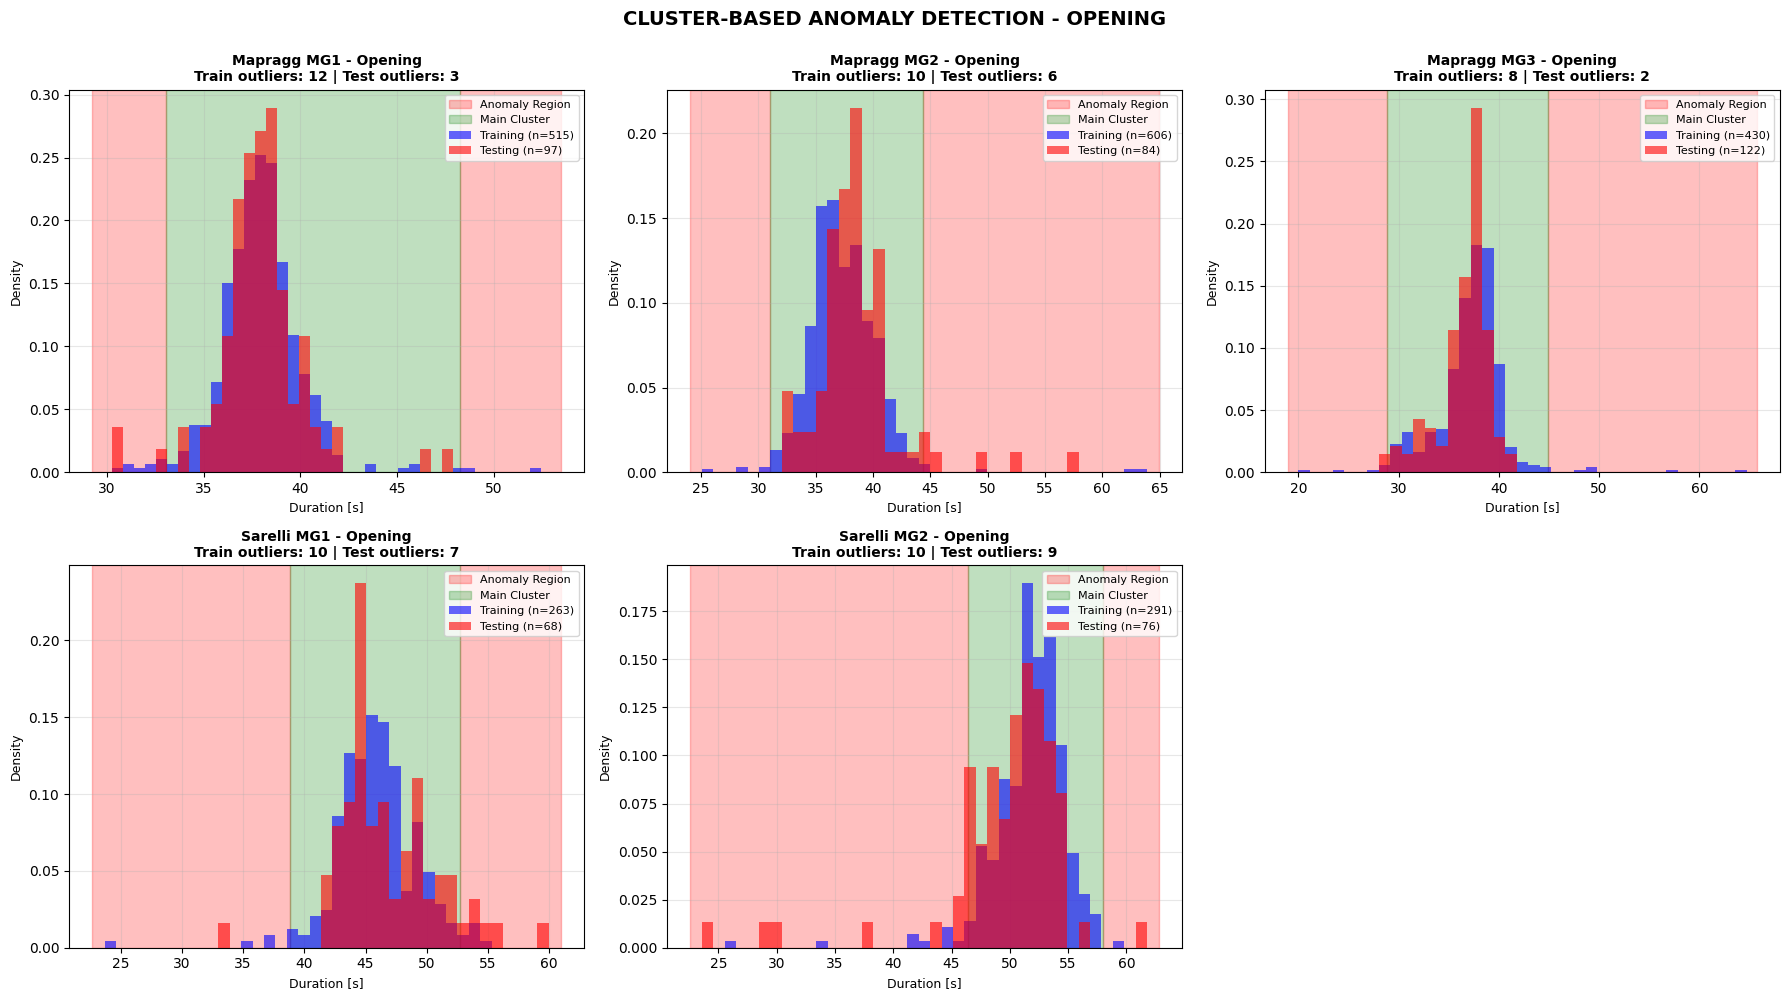

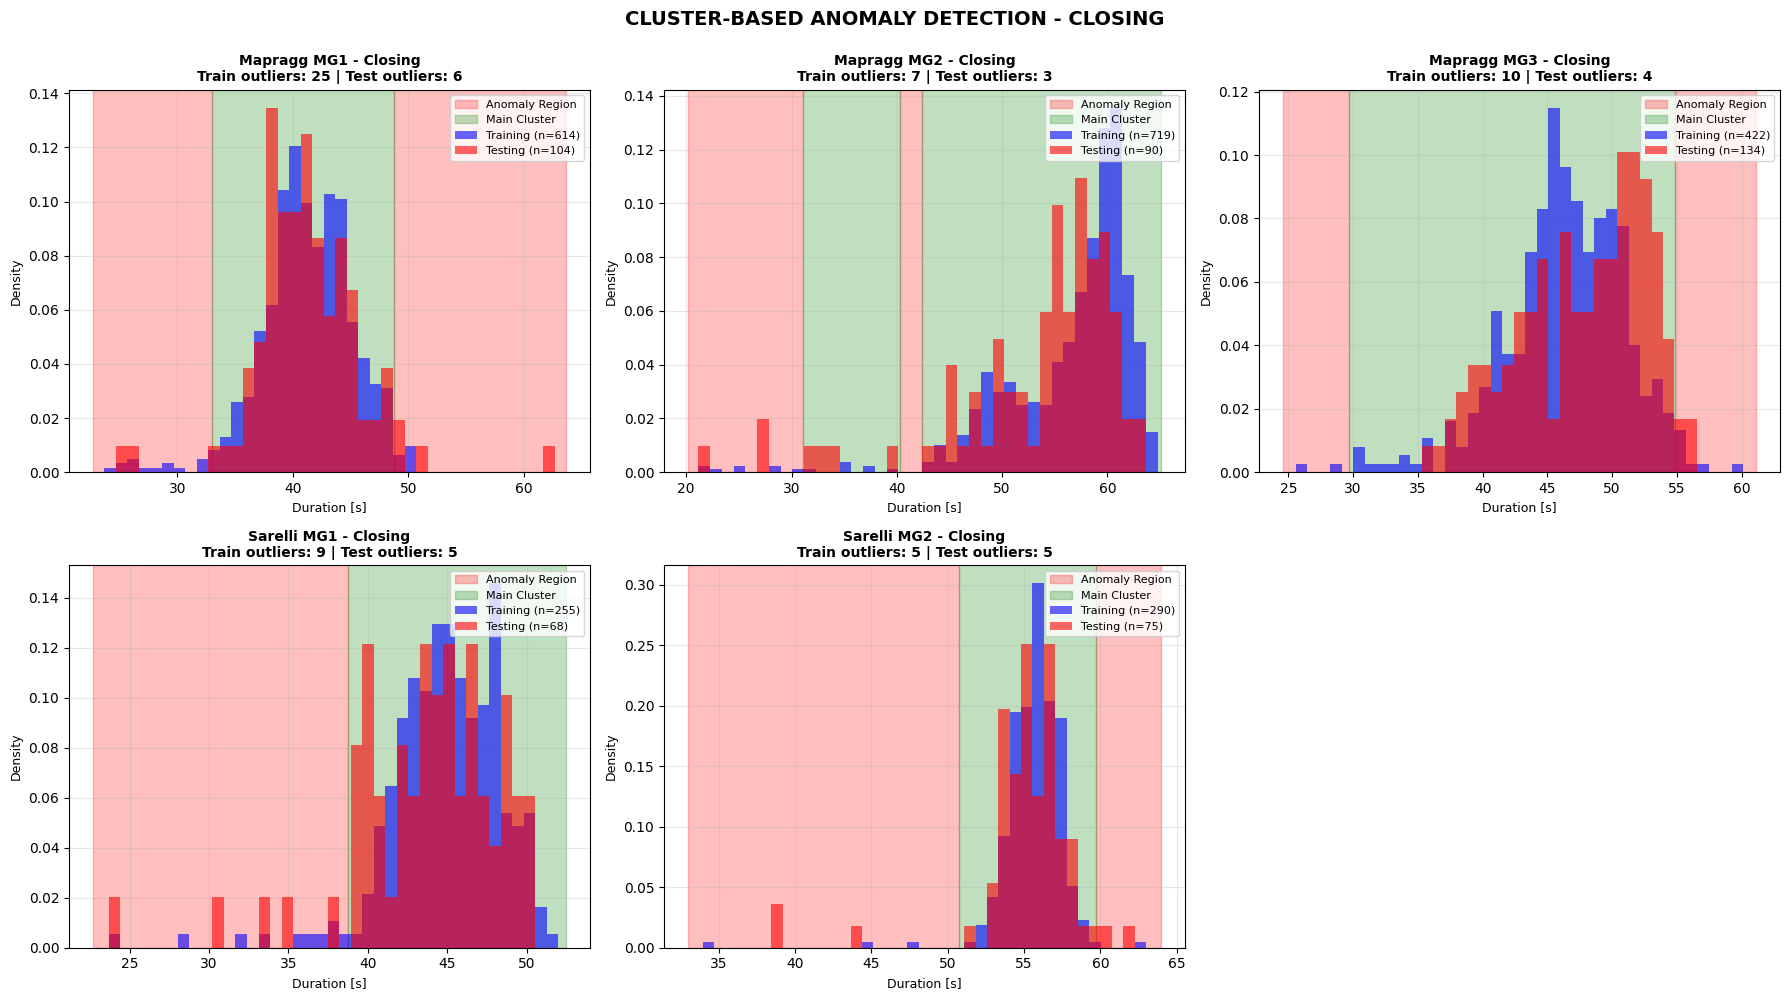


ANOMALOUS EVENTS (sorted by density score, lowest first)
Total anomalies: 194
Showing first 50 events:

1. [Closing] Event 44 at time 1853537.4s in Mapragg_MG1_testing_real_measurements.parquet
   Duration: 62.67s, Density: 0.000000 (threshold: 0.013310)
   Segment: 1, Split: test

2. [Opening] Event 66 at time 2157125.6s in Sarelli_MG1_testing_real_measurements.parquet
   Duration: 59.96s, Density: 0.000000 (threshold: 0.012581)
   Segment: 1, Split: test

3. [Opening] Event 3 at time 88063.8s in Sarelli_MG2_testing_real_measurements.parquet
   Duration: 30.04s, Density: 0.000001 (threshold: 0.013474)
   Segment: 0, Split: test

4. [Opening] Event 31 at time 1303938.6s in Sarelli_MG2_testing_real_measurements.parquet
   Duration: 37.64s, Density: 0.000002 (threshold: 0.013474)
   Segment: 0, Split: test

5. [Closing] Event 85 at time 3035624.1s in Sarelli_MG2_testing_real_measurements.parquet
   Duration: 38.53s, Density: 0.000009 (threshold: 0.013474)
   Segment: 1, Split: test

6. 

In [40]:
df_durations = extract_and_plot_durations(
    valve_detection_results,
    all_segments_resampled,
    model,
    channel_mean,
    channel_std
)

df_with_anomalies, anomaly_counts = run_anomaly_detection(
    df_durations,
    bandwidth=1.0,
    density_threshold_factor=0.10 
)